In [1]:
import os
import sys
sys.path.append('/home/kevinteng/Desktop/DE_Project')
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from coord_conv import CoordConv
import cv2
import utils
import utils_vis
import utils_model
from sklearn.model_selection import train_test_split

/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-package

---------------------

# Retrieving and Preprocess Data

Image size:  100


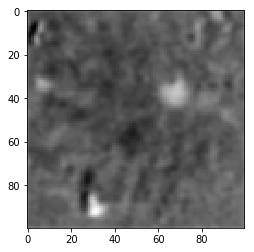

In [2]:
dataset = np.load('/home/kevinteng/Desktop//jpg_to_npy_benchmark/DG13_3-8-17_preprocessed_dF.npy')
NEW_SIZE = 100
#re_list = dataset
re_list = utils.resize(dataset, NEW_SIZE)
IMG_SIZE = re_list.shape[1]

print('Image size: ', IMG_SIZE)
#Dimension for network should include the color channel 
re_list = np.expand_dims(re_list, axis = -1)
#Cast data type to float32 for TensorFlow
# re_list = re_list.astype('float32')
re_list = tf.convert_to_tensor(re_list, dtype = tf.float32)

for img in re_list:
    plt.imshow(np.reshape(img, (IMG_SIZE, IMG_SIZE)), cmap = 'gray')
    plt.show()
    
    break
    
#     if input()=='exit':
#         break

In [3]:
#apply min max norm for mean image
re_list = utils.min_max_norm(re_list)
#max_img_ori = np.expand_dims(max_img_ori, -1)
print('Max value:', np.max(re_list))
print('Min value:', np.min(re_list))


Max value: 1.0
Min value: 0.0


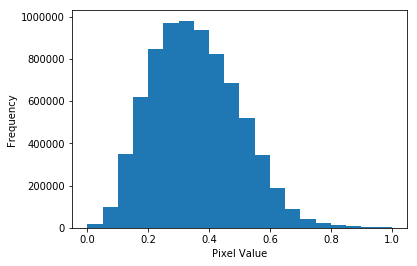

In [4]:
#plot historgram for min max norm image
plt.hist(tf.reshape(re_list, [-1]),20,[0,1])
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()

----------------------------------------------------------


# Helper Function

In [5]:
def create_ran_numbers(img_size):
    '''
    Function to create random coordinates 
    
    @param img_size: Image size 
    
    return:
    random generated x,y coordinates 
    '''
    c1=np.random.randint(img_size, size=1)
    c2=np.random.randint(img_size, size=1)
    c1=tf.convert_to_tensor( c1,dtype=None,dtype_hint=None,name=None)
    c2=tf.convert_to_tensor( c2,dtype=None,dtype_hint=None,name=None)
    return c1,c2

@tf.function
def create_tf_tilecords(coord_list, img_size):
    o1,o2=coord_list
    multiply=tf.constant([img_size*img_size])
    y1=tf.reshape(tf.tile(o1,multiply),[img_size,img_size,1])
    y2=tf.reshape(tf.tile(o2,multiply),[img_size,img_size,1])

    y=tf.concat((y1,y2),axis=2)

    return tf.dtypes.cast(y, tf.float32),tf.dtypes.cast(coord_list, tf.float32)

@tf.function
def tf_create_onehotcords(dat):
    o1,o2=dat
    y1=tf.one_hot(o1,100)
    y2=tf.one_hot(o2,100)
    y2=tf.transpose(y2)
    y=tf.math.multiply(y1,y2)
    #y=tf.transpose(y)
    return y

def create_dat_samples(n):
    '''
    Function to create stacks of coordinates, tiled coordinates, one hot images
    @param n: number of neurons
    '''
    ta = tf.TensorArray(tf.float32, size=0, dynamic_size=True)
    tb = tf.TensorArray(tf.float32, size=0, dynamic_size=True)
    coords = tf.TensorArray(tf.float32, size=0, dynamic_size = True)
    for _ in tf.range(n):
        dat=create_ran_numbers(img_size=100)
        b1,b2=create_tf_tilecords(dat, 100)
        c1=tf_create_onehotcords(dat)
        c1=tf.expand_dims(c1, axis=2, name=None)
        
        #tile coordinates
        ta = ta.write(_, b1/99)  #(n, img_size, img_size, 1)
        #one hot images
        tb = tb.write(_, c1) #(n, img_size, img_size, 1)
        #coordinates
        coords = coords.write(_, dat) #(n, 2, 1)
    return coords.stack(), ta.stack(),tb.stack()

def neuron_like_image(n_neurons):
    '''
    Function to paint neuron-like images
     @param n_neurons: number of neurons
    '''
    _,_,one_hot_imgs = create_dat_samples(n_neurons)
    stack_imgs = tf.reduce_sum(one_hot_imgs, axis = 0)
    return tf.expand_dims(stack_imgs, axis = 0) #(1, img_size, img_size, 1)

def stack4plot(one_hot_imgs):
    '''
    Functions to sum all one hot images along axis=0 for easy plot
    '''
    return tf.squeeze(tf.reduce_sum(one_hot_imgs, axis = 0))

---

# Validation

In [6]:
n_neurons = 40
img_size = 100
coords,_, ori_one_hot_imgs = create_dat_samples(n_neurons)
coords = tf.reshape(coords, [n_neurons, 1,1,2])
tf.print(tf.shape(coords))

[40 1 1 2]


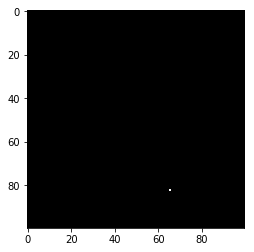

In [7]:
plt.imshow(tf.squeeze(ori_one_hot_imgs[0]), cmap = 'gray')

-----------------------------------

# Model

In [8]:
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import InputLayer, Conv2DTranspose, Activation, BatchNormalization
from tensorflow.keras.layers import Input, Softmax
from tensorflow.keras.regularizers import l1
from utils_model import conv_block, coordconv_block, up_block, up_coord_block
from tensorflow.keras import layers

def encoder(inps, img_size):
    #1st block
    coord01 = CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
                        filters = 32, kernel_size = 3, padding='same')(inps)
    leaky01 =tf.keras.layers.LeakyReLU(0.5)(coord01)
    coord02 = CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
                        filters = 1, kernel_size = 3, padding='same')(leaky01)
    leaky02 = tf.keras.layers.LeakyReLU(0.5)(coord02)
    add01 = tf.keras.layers.Add()([leaky02, inps])
    
    #2nd block
    coord03 =  CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
                      filters = 128, kernel_size = 3, padding='same')(add01)
    leaky03 = tf.keras.layers.LeakyReLU(0.5)(coord03)
    coord04 = CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
                 filters = 1, kernel_size = 3, padding='same')(leaky03)
    leaky04 = tf.keras.layers.LeakyReLU(0.5)(coord04)
    add02 = tf.keras.layers.Add()([leaky04, add01])
    
    #3rd block
    coord05 = CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
                    filters = 256, kernel_size = 3, padding='same')(add02)
    leaky05 = tf.keras.layers.LeakyReLU(0.5)(coord05)
    coord06 = CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
                        filters = 1, kernel_size = 3, padding='same')(leaky05)
    leaky06 = tf.keras.layers.LeakyReLU(0.5)(coord06)
    add03 = tf.keras.layers.Add()([leaky06, add02])

    #4th block
    coord07 =CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
                       filters = 128, kernel_size = 3, padding='same')(add03)
    leaky07 = tf.keras.layers.LeakyReLU(0.5)(coord07)
    coord08 = CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
                 filters = 1, kernel_size = 3, padding='same')(leaky07)
    leaky08 = tf.keras.layers.LeakyReLU(0.5)(coord08)
    add04 =tf.keras.layers.Add()([leaky08, add03])
    
    #5th block
    coord09 =CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
                       filters = 64, kernel_size = 3, padding='same')(add04)
    leaky09 = tf.keras.layers.LeakyReLU(0.5)(coord09)
    coord10=CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
                 filters = 1, kernel_size = 3, padding='same')(leaky09)
    leaky10 = tf.keras.layers.LeakyReLU(0.5)(coord10)
    add05 = tf.keras.layers.Add()([leaky10, add04])
    
    #6th block
    coord11 = CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
                    filters = 32, kernel_size = 3, padding='same')(add05)
    leaky11 = tf.keras.layers.LeakyReLU(0.5)(coord11)
    coord12 = CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
                 filters = 1, kernel_size = 3, padding='same')(leaky11)
    leaky12 = tf.keras.layers.LeakyReLU(0.5)(coord12)
    add06 = tf.keras.layers.Add()([leaky12, coord11])
    output = Conv2D(1, kernel_size = 3,activation = 'linear', padding='same')(add06)
    
    return output


def de_conv(input_tensor):
    coord01 = CoordConv(x_dim = 100, y_dim = 100, with_r = False, filters = 100,
              kernel_size = 1, padding='same', activation='relu')(input_tensor)
    conv01 = Conv2D(filters = 50, kernel_size = 1, strides = 1, padding = "same", activation = 'relu')(coord01)
    conv02 = Conv2D(filters = 50, kernel_size = 1, strides = 1, padding = "same", activation = 'relu')(conv01)
    conv03 = Conv2D(filters = 100, kernel_size = 1, strides = 1, padding = "same", activation = 'relu')(conv02)
    conv04 = Conv2D(filters = 100, kernel_size = 1, strides = 1, padding = "same", activation = 'relu')(conv03)
    conv05 = Conv2D(filters = 1, kernel_size = 1, strides = 1, padding = "same" )(conv04)
    f1 = Flatten()(conv05)
    output = Softmax(axis = -1)(f1)

    return output

def latent_space(encoded_imgs, deconv_imgs, coords, batch_size):
    '''
    This function construct the dot product of the output of an encoder(batch_size, img_size, img_size, 1) 
    with the one hot images generated by decoord-conv(n_neurons, img_size, img_size, 1), which yields
    similarity score (batch_size, n_neurons). Similarity score is then concatenate to the last layer of the 
    input coordinates with the corresponding batch (batch_size, n_neurons, 3)
    
    @encoded_imgs: output images from the encoder
    @deconv_imgs: one hot images generated from the coordinate list 
    @coords: A list of coordinates generated randomly based on the number of neurons
    @batch_size: Batch size of the input image for encoder, to allocate size for writing in loop
    
    return: 
        latent space with dim (batch_size, n_neurons, 3, 1)
    '''
    similarity_score = tf.tensordot(encoded_imgs, deconv_imgs, [[1,2,3],[1,2,3]]) #(batch_size, n_neurons)
    squeeze_coords = tf.squeeze(coords/(img_size-1)) #coords dim (n_neurons, 1, 1, 2) = > (n_neurons, 2)
    latent = tf.TensorArray(tf.float32, size=0, dynamic_size=True)
    for i in tf.range(batch_size):
        concat = tf.stack((squeeze_coords[:,-2], squeeze_coords[:,-1], similarity_score[i]), axis=-1)    
        latent = latent.write(i, concat) #(batch_size, n_neurons, 3)
    return tf.expand_dims(latent.stack(), axis = -1), similarity_score

def decoder(latent_dim, img_size):
    flat_01 = Flatten()(latent_dim)
    dense_01 = Dense(25*25*32, activation = 'relu')(flat_01)
    dense_01 = Reshape((25,25,32))(dense_01)
    up_01 = up_block(dense_01, up_size = 2, filters = 32, kernel_size = 3,
                            strides = 1, padding = 'same', activation = 'relu')
    up_02 = up_block(up_01, up_size = 2, filters = 64, kernel_size = 3,
                            strides = 1, padding = 'same', activation = 'relu')
    output = coordconv_block(up_02, x_dim = img_size, y_dim = img_size, 
                              filters = 1, kernel_size = 3, strides = 1,
                              padding = 'same', activation = None)
    return output

class learnable_coords(layers.Layer):
    def __init__(self, coords):
        super(learnable_coords, self).__init__()
        self.learned_coords = tf.Variable((coords), trainable = True)

    def __call__(self, img_size):
        y = self.learned_coords/(img_size-1) #normalize the coordinates
    #         y = tf.clip_by_value(y, clip_value_min=0, clip_value_max=1) #clip values
        return y
    
def dataset_parse(dataset_path, NEW_SIZE):
    dataset = np.load(dataset_path)
    #re_list = dataset
    re_list = utils.resize(dataset, NEW_SIZE)
    #Dimension for network should include the color channel 
    re_list = np.expand_dims(re_list, axis = -1)
    #Cast data type to float32 for TensorFlow
    # re_list = re_list.astype('float32')
    re_list = tf.convert_to_tensor(re_list, dtype = tf.float32)
    
    return re_list

def stack4plot(one_hot_imgs):
    '''
    Functions to sum all one hot images along axis=0 for easy plot
    '''
    return tf.squeeze(tf.reduce_sum(one_hot_imgs, axis = 0))

In [9]:
# def encoder02(inps, img_size):
#     #1st block
#     coord01 = CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
#                         filters = 256, kernel_size = 3, padding='same')(inps)
#     leaky01 =tf.keras.layers.LeakyReLU(0.5)(coord01)
#     conv01 = Conv2D(filters = 128, kernel_size = 3, strides = 1, padding = "same", activation = 'relu')(leaky01 )
#     leaky02 = tf.keras.layers.LeakyReLU(0.5)(conv01)
#     output = Conv2D(1, kernel_size = 3,activation = 'linear', padding='same')(leaky02 )
#     return output

-----------------------------------------------------------------

## Build Model

In [10]:
#build encoder 
inps = Input(shape=(img_size, img_size, 1))
encoder_model = Model(inps, encoder(inps, img_size))

#build coord model
inp = Input(shape=(100, 100,2)) #(batch_size, img_size, img_size, 2)
de_coordconv = Model(inp, de_conv(inp))
de_coordconv.load_weights("best_class_model100_02.hdf5")

#decoder
latent_dim = Input(shape=(n_neurons, 3, 1))
decoder_model = Model(latent_dim, decoder(latent_dim, img_size))

#learnable coords
l_coords = learnable_coords(coords)

In [11]:
# encoder_model.summary()

## Train Model

--------------------------------------

In [12]:
lr=0.001
opt = tf.keras.optimizers.Adam(lr)
loss_fn = tf.losses.MeanSquaredError()

@tf.function
def train_fn(inp_imgs, coords, img_size, batch_size):
    with tf.GradientTape() as tape:
        #custom layer for updating coordinates
        updated_coords = l_coords(img_size)
        m1 = tf.constant([1,img_size,img_size,1], tf.int32) #multiplier for tiling 
        #tile coordinates
        tile_cd = tf.tile(updated_coords, m1)
        #de-coordconv model
        de_coordconv.trainable = False #freeze de-coordconv
        one_hot_imgs = tf.reshape(de_coordconv(tile_cd),[-1,img_size, img_size, 1]) #(n_neurons, img_size, img_size, 1)
        #output from encoder 
        encoder_output = encoder_model(inp_imgs)
        #latent space
        latent, similarity_score = latent_space(encoder_output, one_hot_imgs, coords, batch_size)#(batch_size, n_neurons, 3, 1)
        #reconstruction 
        reconstruction = decoder_model(latent)
        loss = loss_fn(inp_imgs, reconstruction)
        
    varis = encoder_model.trainable_variables + decoder_model.trainable_variables + l_coords.trainable_variables
    grad_model = tape.gradient(loss, varis)
#     grad_coords = tape.gradient(loss, l_coords.trainable_variables)
    opt.apply_gradients(zip(grad_model, varis))
#     opt.apply_gradients(zip(grad_coords, l_coords.trainable_variables))
    
    return loss, updated_coords, one_hot_imgs, encoder_output, similarity_score, reconstruction, grad_model 

In [13]:
# ds_dir = '/home/kevinteng/Desktop/jpg_to_npy_benchmark/'

# for d in sorted(os.listdir(ds_dir)):
#     merge_d = os.path.join(ds_dir+d)
#     imgs = dataset_parse(merge_d, 100)
#     break

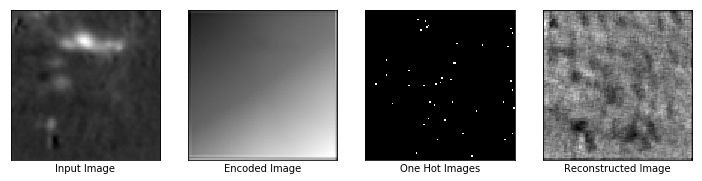

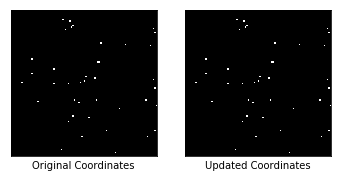

Epochs: 1, Loss: 0.022345831617712975
Similarity scores: [ 0.5605759  -0.23952928 -0.18384577  0.6802376  -0.06906854  0.3475204
  0.13546802  0.8767311  -0.25480685 -0.28308138 -0.11820992 -0.03194449
 -0.32987976  0.06507415  0.4263163   0.11808082  0.44717613 -0.30573267
  0.46350256  0.22166876  0.24494855 -0.28232557  0.1370471   0.01236379
 -0.11140262  0.04878316  0.3819704  -0.02533189 -0.02752104 -0.2381799
  0.02370844 -0.08473852 -0.03235718 -0.01749716  0.21429929  0.8528164
 -0.25793883  0.52999324  0.49556518  0.5573277 ]
Updated Coordinates: [[[0.6565836  0.82827264]]]
Gradient min:-4.113623435841873e-05, max:4.4646560127148405e-05



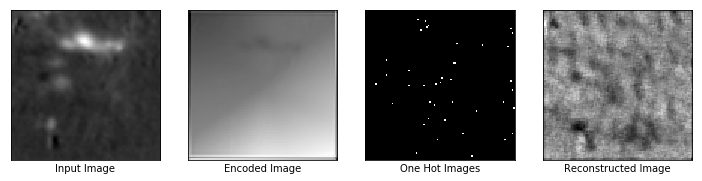

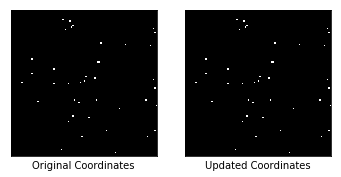

Epochs: 2, Loss: 0.0218545813113451
Similarity scores: [ 0.30816534 -0.07702431 -0.07696928  0.20363864 -0.03364667  0.20772676
  0.08867311  0.41892084 -0.11284474 -0.12823915 -0.03967971 -0.0438773
 -0.14467636  0.04302413  0.18990831 -0.04328408  0.2037636  -0.1170356
  0.32473543  0.15097646  0.1722398  -0.12092974  0.03766169 -0.05147559
 -0.01261908 -0.0246576   0.25925526 -0.02928702 -0.04436872 -0.06301919
 -0.00339868 -0.07196607 -0.02728029 -0.02536464  0.10188164  0.4893421
 -0.11439615  0.20420738  0.32301128  0.23990427]
Updated Coordinates: [[[0.6565715 0.8282776]]]
Gradient min:-0.0001015366506180726, max:0.00010642626148182899



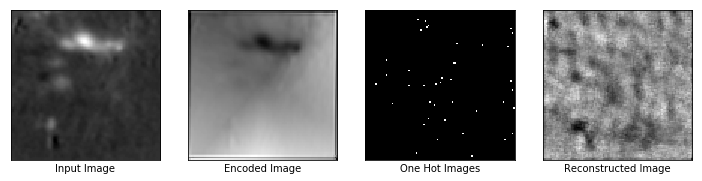

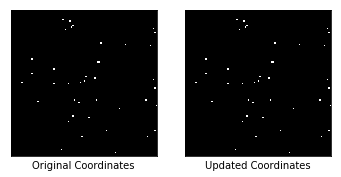

Epochs: 3, Loss: 0.020222757011651993
Similarity scores: [ 0.19139336  0.00413363 -0.03834117 -0.10040478 -0.04031108  0.14849347
  0.0734058   0.2104022  -0.07520624 -0.09731638 -0.01521207 -0.09536607
 -0.08866503  0.03598886  0.21574497 -0.05602925  0.10458247 -0.03340563
  0.2800953   0.12458126  0.14760698 -0.06272939  0.18709815 -0.01910474
  0.06187255  0.19566786  0.2610143  -0.073174   -0.09296609  0.02810017
 -0.03053603 -0.18340054 -0.04660728 -0.05890591  0.05229036  0.3233114
 -0.07827576  0.00845626  0.25974688  0.14752969]
Updated Coordinates: [[[0.6565638 0.8282794]]]
Gradient min:-0.0007590545574203134, max:0.0006436933181248605



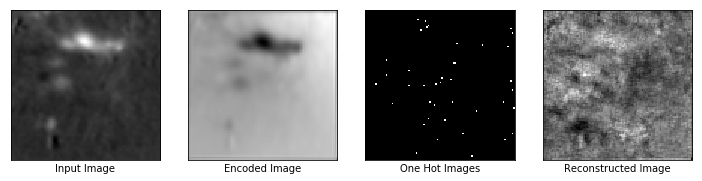

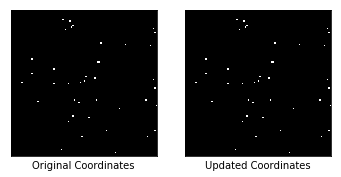

Epochs: 4, Loss: 0.0053310701623559
Similarity scores: [ 0.4201643  -0.01088968 -0.22400884  0.36075014 -0.44361943  0.28684086
  0.20606196  0.6782154   0.21434446 -0.00693341 -0.3274871  -0.05359788
  0.21492696  0.13262849  1.2370334   0.7275863   0.48908406 -0.05057726
  0.3804231   0.2055109   0.23303217  0.36517933  1.443844    0.5454288
  0.10914569  1.703184    0.9909087  -0.13781516 -0.05942087 -0.04540887
  0.05229778 -0.9601638  -0.09276485 -0.07523475  0.23198695  0.64645195
  0.16207987  0.37186527  0.40131286  0.80272394]
Updated Coordinates: [[[0.6565554 0.8282831]]]
Gradient min:-0.0032900047954171896, max:0.0032850804273039103



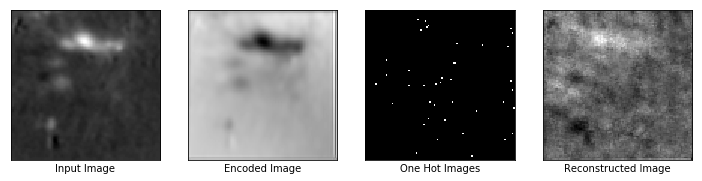

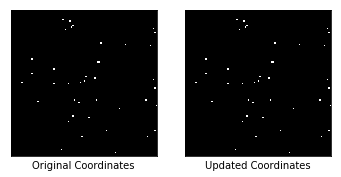

Epochs: 5, Loss: 0.004441419616341591
Similarity scores: [ 0.14202915  0.5412129   0.1059195  -1.1766468  -0.36451024  0.19034903
  0.2568195  -0.0361849   0.46772432  0.31757045 -0.08860184 -0.37320274
  0.62633675  0.23622218  1.2019259   0.6226933   0.05049512  0.54837984
  0.592426    0.29716378  0.37264588  0.70406234  0.7227917  -0.3814337
  0.49329692  1.5400796  -0.37147808 -0.20822707 -0.41665342  0.5814649
 -0.21572113 -1.279801   -0.09159862 -0.13781957  0.03993586  0.29855022
  0.4208006  -1.0188773   0.40398005  0.1106087 ]
Updated Coordinates: [[[0.6565075 0.8283063]]]
Gradient min:-0.0011645271442830563, max:0.001091855694539845



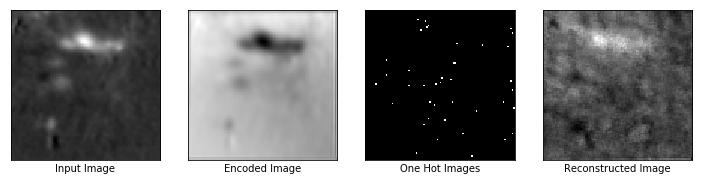

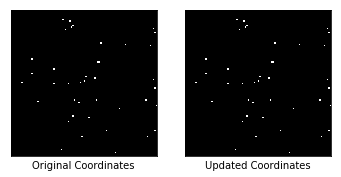

Epochs: 6, Loss: 0.00394178694114089
Similarity scores: [ 0.06391759  0.8127904   0.37555856 -0.70471555 -0.322033    0.15059277
  0.29606822 -0.12282717  0.91386557  0.7513813   0.03484541 -0.32570288
  1.1567968   0.30157235  0.49261692  0.3787691  -0.06074905  0.928586
  0.6256133   0.32480565  0.40990362  1.235347    0.65200657 -0.46490183
  0.63456786  1.2469406   0.11298718 -0.1638057  -0.38273373  0.84759146
 -0.22198485 -1.3275127  -0.03369403 -0.09474656 -0.01285782  0.20438644
  0.84625345 -0.563881    0.37458786  0.01144581]
Updated Coordinates: [[[0.6564981 0.8283163]]]
Gradient min:-0.00033330151927657425, max:0.0004061356303282082



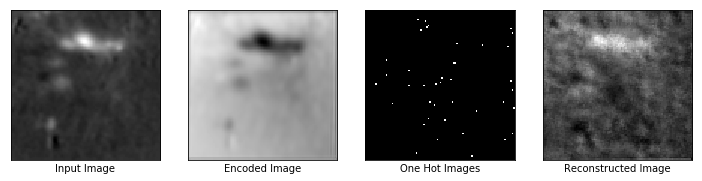

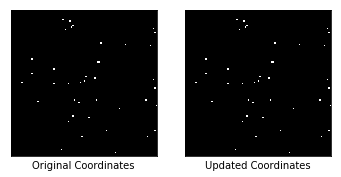

Epochs: 7, Loss: 0.0038594231009483337
Similarity scores: [ 0.0900905   1.0431383   0.5311561  -0.5875679  -0.2974324   0.19912288
  0.38194904 -0.10124702  1.0780817   0.9493546   0.12399566 -0.34094605
  1.3803535   0.3929052   0.31688192  0.20802069 -0.09354364  1.1918942
  0.7743832   0.4155576   0.5200588   1.4138014   0.47512418 -0.65691334
  0.8332005   0.8948378   0.16956854 -0.13925819 -0.40255782  1.0690598
 -0.22590019 -1.4474862   0.01873791 -0.05946733 -0.00192219  0.28732455
  1.0290489  -0.43280825  0.45833886 -0.00271138]
Updated Coordinates: [[[0.6565449  0.82830095]]]
Gradient min:-0.0008184293983504176, max:0.0009124329662881792



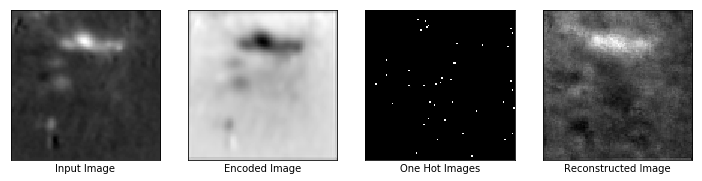

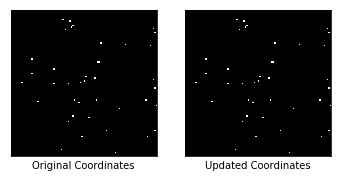

Epochs: 8, Loss: 0.00363759882748127
Similarity scores: [ 0.5430061   0.7224019   0.207103    0.57495785 -0.51175326  0.39952278
  0.48458195  0.88413817  0.77463585  0.58474433 -0.2402568  -0.22111225
  1.0418441   0.44611108  1.1260697   0.68616897  0.51798403  0.791473
  0.85842323  0.47743824  0.57027763  1.1804353   1.1573616  -0.11409231
  0.59826165  1.4595207   0.5497257  -0.12180511 -0.26139718  0.6621196
 -0.03990091 -1.4960754  -0.01406883 -0.0344389   0.27569708  0.862903
  0.7054424   0.3842975   0.66406035  0.8219498 ]
Updated Coordinates: [[[0.65664285 0.82828057]]]
Gradient min:-0.0008416484924964607, max:0.0009485649643465877



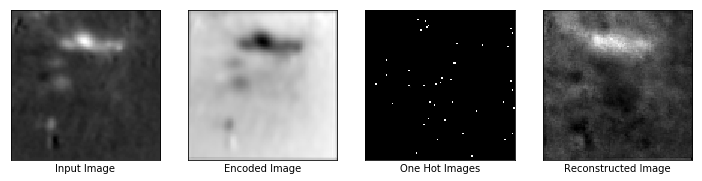

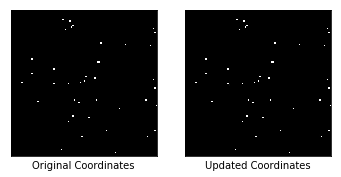

Epochs: 9, Loss: 0.003396418411284685
Similarity scores: [ 0.97063476  0.5569594   0.12037123  1.377791   -0.58718145  0.61116827
  0.6324472   1.6252999   0.6822052   0.49350077 -0.38789943 -0.03632423
  0.85935026  0.5514664   1.6648072   0.95146835  0.95732677  0.6241284
  0.9801696   0.57955587  0.6662988   1.0416069   1.6708007   0.23743816
  0.46143007  1.8424815   0.97963446 -0.03276597 -0.0634949   0.43243265
  0.17632467 -1.466714    0.05199265  0.07440278  0.53277826  1.3953553
  0.61850655  1.0572836   0.87754774  1.4434954 ]
Updated Coordinates: [[[0.6566706 0.8283337]]]
Gradient min:-0.0007040728232823312, max:0.0009829639457166195



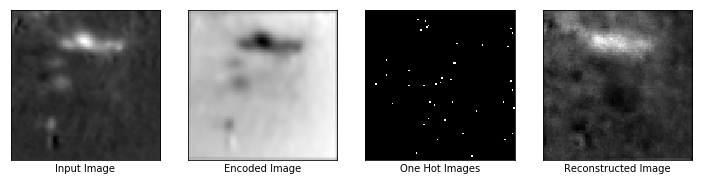

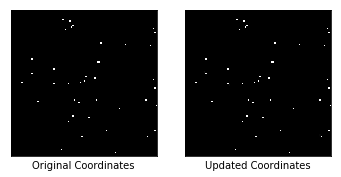

Epochs: 10, Loss: 0.003273940645158291
Similarity scores: [ 1.2313198   0.5644817   0.16339117  1.7371387  -0.6019208   0.7769466
  0.7795483   2.0838432   0.7048561   0.50772744 -0.4164815   0.10986052
  0.85395885  0.6802685   1.9909716   1.0370436   1.2411742   0.610652
  1.1070638   0.68612444  0.77421623  1.0647848   2.0145652   0.43763235
  0.48625097  2.0841093   1.2559973   0.10863797  0.0923616   0.40730253
  0.33032867 -1.4435852   0.16577102  0.21444686  0.7164043   1.7220572
  0.6369618   1.373741    1.0432487   1.8276671 ]
Updated Coordinates: [[[0.65667    0.82838416]]]
Gradient min:-0.0010526353726163507, max:0.001194053329527378



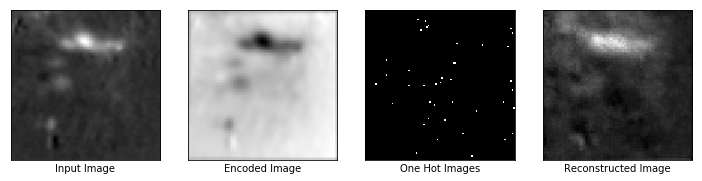

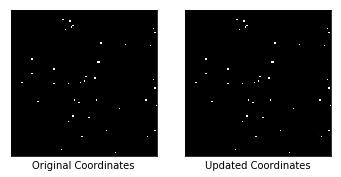

Epochs: 11, Loss: 0.00313939549960196
Similarity scores: [ 1.2507533   0.8723496   0.34857443  1.4286367  -0.55672455  0.86609465
  0.93481106  2.0034063   0.79578894  0.59703773 -0.29068834  0.08704472
  1.0041491   0.86333275  1.9358219   0.9722222   1.204256    0.85796386
  1.31954     0.83444303  0.9451265   1.2138648   1.8509868   0.22685872
  0.817833    1.9653836   0.90007126  0.20469944  0.05707847  0.72648495
  0.34484306 -1.5478145   0.29439968  0.32211602  0.76031744  1.7670555
  0.72813606  1.0468284   1.1840913   1.7192144 ]
Updated Coordinates: [[[0.65664124 0.8284272 ]]]
Gradient min:-0.0009183015208691359, max:0.001295564929023385



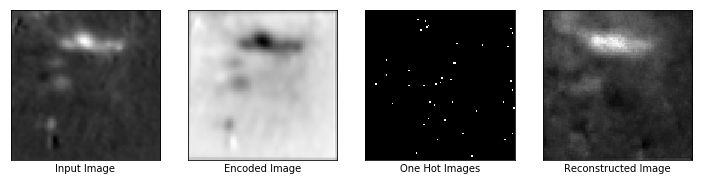

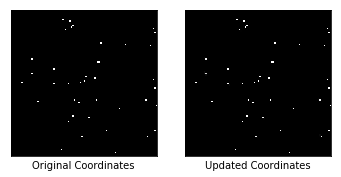

Epochs: 12, Loss: 0.0031290389597415924
Similarity scores: [ 1.2347625   1.3298725   0.5653726   1.02905    -0.4928906   0.9687972
  1.1073084   1.8308804   0.8317632   0.64960504 -0.12328213 -0.02130318
  1.1253476   1.0731395   1.7669861   0.853802    1.0764077   1.3002787
  1.6436111   1.0430473   1.186984    1.306965    1.5232109  -0.14808598
  1.2543064   1.7132008   0.3323769   0.23273589 -0.06543914  1.2899641
  0.3022559  -1.7421367   0.3996537   0.3826283   0.7725295   1.783358
  0.7697872   0.4885851   1.3778617   1.5079849 ]
Updated Coordinates: [[[0.65662014 0.8284184 ]]]
Gradient min:-0.0014696919824928045, max:0.0011087942402809858



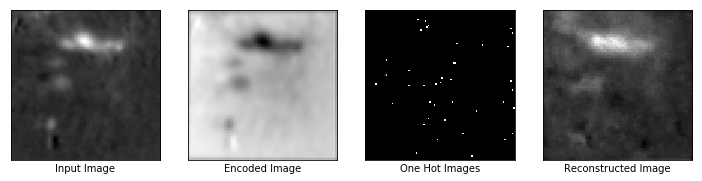

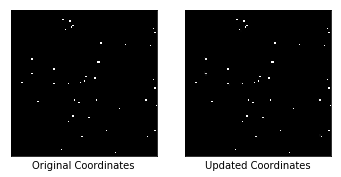

Epochs: 13, Loss: 0.0030175279825925827
Similarity scores: [ 1.2969444   1.995604    0.97124743  0.7148743  -0.35771853  1.1511908
  1.3471456   1.6506273   1.0351174   0.8678434   0.13564877 -0.01565222
  1.4315664   1.346033    1.5398256   0.6230303   1.0106852   2.007534
  2.1486094   1.3878593   1.5870427   1.561996    1.1770587  -0.33846733
  1.9296138   1.3907183   0.07345206  0.36776143 -0.06926804  2.0759847
  0.34321517 -1.7936859   0.60527766  0.52483565  0.84381276  1.8217219
  0.96471745  0.08774616  1.6915836   1.2979332 ]
Updated Coordinates: [[[0.6566207  0.82838726]]]
Gradient min:-0.0015075183473527431, max:0.0011863142717629671



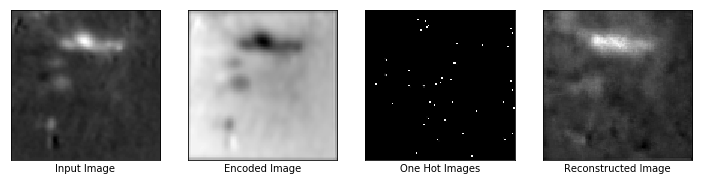

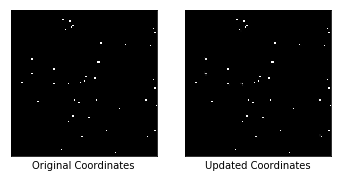

Epochs: 14, Loss: 0.002870457014068961
Similarity scores: [ 1.3930556   2.4055078   1.2111576   0.5847584  -0.3307583   1.3362613
  1.5578047   1.6495413   1.144972    0.98906696  0.24591398  0.0227355
  1.588276    1.5704979   1.4868964   0.533063    1.0425078   2.4101262
  2.5675895   1.6653186   1.9065615   1.7080531   0.9869952  -0.4149843
  2.3571455   1.2843359  -0.03544929  0.4549284  -0.03539973  2.5327837
  0.40134382 -1.8260916   0.735267    0.6311374   0.930488    1.9506489
  1.08046    -0.03509281  1.9837588   1.2677933 ]
Updated Coordinates: [[[0.6565558 0.8284201]]]
Gradient min:-0.0010461952770128846, max:0.0008916740771383047



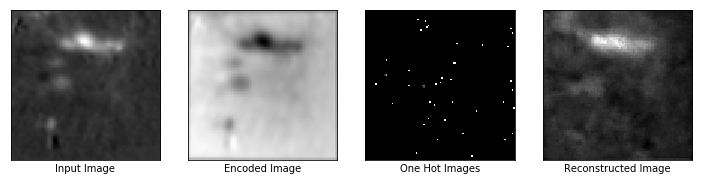

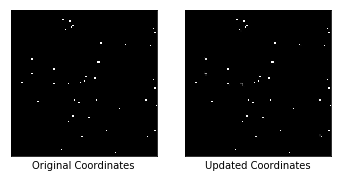

Epochs: 15, Loss: 0.0028273139614611864
Similarity scores: [ 1.7118647   2.3366244   1.1219324   1.198762   -0.3843773   1.5888698
  1.7584233   2.1146653   0.96875566  0.7824863   0.1709025   0.05474282
  1.3388195   1.742001    1.7063805   0.7075197   1.3128586   2.2858574
  2.960713    1.9000514   2.1735604   1.5313469   1.335873   -0.3133544
  2.4116418   1.4210856   0.25844476  0.52318853 -0.00375687  2.454529
  0.49046487 -1.9050333   0.81903124  0.7232174   1.1188902   2.381975
  0.90280133  0.54587656  2.3319116   1.6201469 ]
Updated Coordinates: [[[0.6565712 0.8283336]]]
Gradient min:-0.0011435335036367178, max:0.000856500759255141



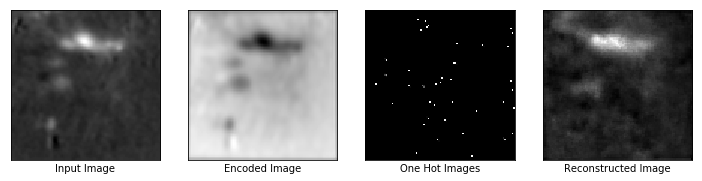

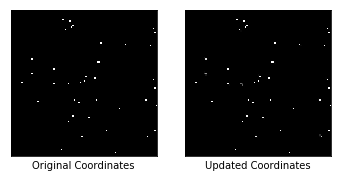

Epochs: 16, Loss: 0.002887672046199441
Similarity scores: [ 2.029382    2.1113524   0.95253384  1.7639679  -0.46211562  1.772273
  1.8810662   2.6489666   0.8207902   0.6257388   0.04754669  0.16914788
  1.0637019   1.8307816   2.0931273   0.968147    1.6874782   1.9823134
  3.0749745   2.0119724   2.2784941   1.3337414   1.7559751  -0.09425094
  2.2228553   1.7695417   0.62748456  0.61995083  0.11504379  2.1087155
  0.64280033 -1.8463024   0.90015954  0.8326318   1.3250921   2.7387009
  0.7607877   1.1165335   2.5250728   2.0402844 ]
Updated Coordinates: [[[0.65661514 0.8283063 ]]]
Gradient min:-0.0012656403705477715, max:0.001446478650905192



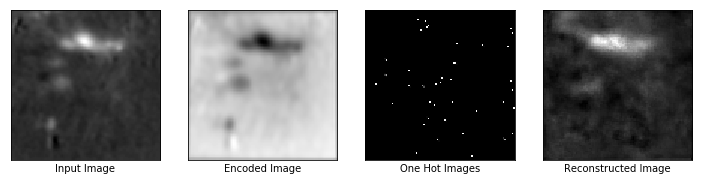

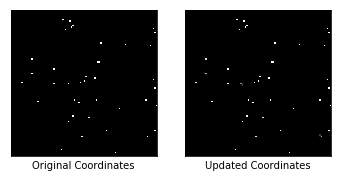

Epochs: 17, Loss: 0.0029256001580506563
Similarity scores: [ 2.2404754   1.9375952   0.9167583   2.2016668  -0.48714307  1.8935988
  1.9706775   3.089196    0.9238753   0.6712094   0.01277129  0.4350583
  1.1175908   1.8994676   2.5832086   1.230838    2.0181854   1.7995025
  2.9608972   2.0452135   2.275719    1.4508858   2.3761444   0.32432932
  2.0227928   2.3640053   1.1873924   0.809224    0.38242257  1.7944798
  0.8784669  -1.6789109   1.046953    1.0141754   1.5250087   2.9545333
  0.85383177  1.6268915   2.593662    2.4963129 ]
Updated Coordinates: [[[0.656596   0.82834774]]]
Gradient min:-0.0018470649374648929, max:0.002232526196166873



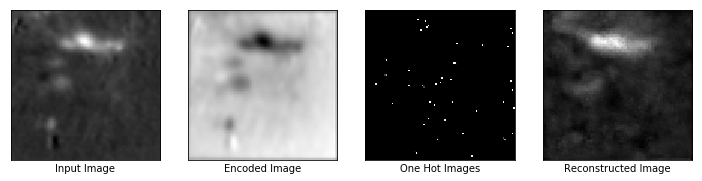

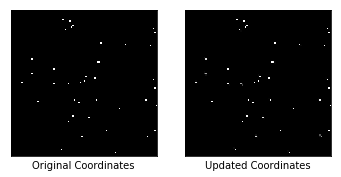

Epochs: 18, Loss: 0.002788839628919959
Similarity scores: [ 2.2680137   1.6280872   0.7314048   2.2233834  -0.603758    1.8701273
  1.9345006   3.1893091   0.89280164  0.61734223 -0.13922402  0.47123313
  1.0366689   1.8510311   2.8152993   1.3735142   2.0946376   1.5676554
  2.724685    1.9470881   2.1215994   1.420195    2.5994942   0.41997707
  1.7116294   2.6270401   1.4107337   0.8165513   0.4182604   1.3606849
  0.920691   -1.7042873   1.0273933   1.0196083   1.5559354   2.9712996
  0.80885357  1.6610417   2.5282993   2.627203  ]
Updated Coordinates: [[[0.6566014 0.8283621]]]
Gradient min:-0.001282852957956493, max:0.0009104771306738257



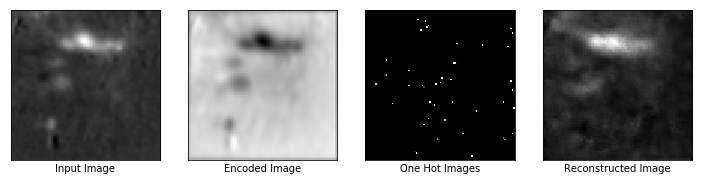

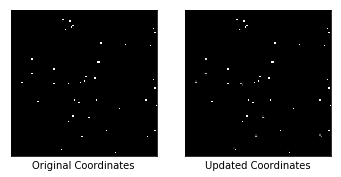

Epochs: 19, Loss: 0.0029696745332330465
Similarity scores: [ 2.0785208   2.0320065   1.0103014   1.4280728  -0.519115    1.7976346
  1.976599    2.7811306   1.2123731   0.87153137  0.04315799  0.4914038
  1.4473428   1.9233166   2.689811    1.1936135   1.9118329   2.044218
  2.6959972   1.9634123   2.140678    1.8113142   2.4509828   0.335598
  1.9384795   2.5805004   1.1134229   0.8980693   0.42403355  1.7045395
  0.9344791  -1.6759142   1.1243709   1.097997    1.5059452   2.7025826
  1.102802    0.9545978   2.443739    2.3443856 ]
Updated Coordinates: [[[0.65660363 0.82835174]]]
Gradient min:-0.0017491797916591167, max:0.0013560395454987884



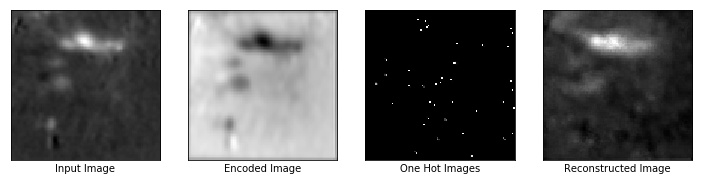

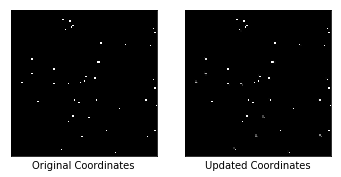

Epochs: 20, Loss: 0.0030327830463647842
Similarity scores: [ 2.0114803   2.7339933   1.5089395   0.73756236 -0.33541283  1.8386766
  2.1431072   2.458713    1.5409256   1.2361225   0.38477147  0.5563611
  1.8661727   2.122615    2.48472     0.981882    1.785048    2.7278538
  3.016963    2.1724892   2.4129755   2.1814108   2.153047    0.2919475
  2.552446    2.3764596   0.7355571   1.054895    0.47588637  2.5832694
  1.0012348  -1.566863    1.2957866   1.2519797   1.5299916   2.5766788
  1.4583455   0.38688892  2.5315938   2.087072  ]
Updated Coordinates: [[[0.65655315 0.82837784]]]
Gradient min:-0.002657797886058688, max:0.0021570343524217606



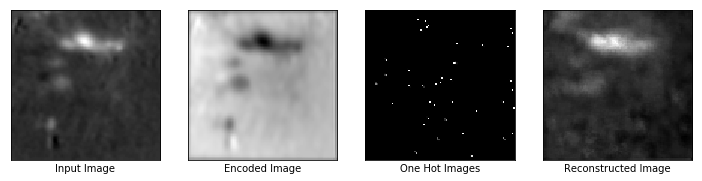

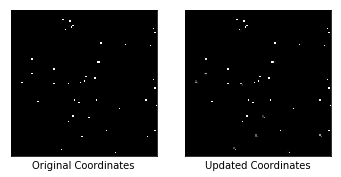

Epochs: 21, Loss: 0.0028573847375810146
Similarity scores: [ 2.0952346   3.3142169   1.8717566   0.6185901  -0.27860877  1.9744462
  2.3995366   2.421966    1.7804263   1.488328    0.5799324   0.5843325
  2.2069342   2.4057033   2.427971    0.8663932   1.8033563   3.3304586
  3.415003    2.4423366   2.7313278   2.5056887   2.0265284   0.20962411
  3.0771914   2.3276935   0.48779333  1.204057    0.48726633  3.2218187
  1.0773834  -1.6465086   1.4717661   1.4069757   1.6371611   2.6757736
  1.6948588   0.22546041  2.760487    2.032451  ]
Updated Coordinates: [[[0.65648556 0.8283375 ]]]
Gradient min:-0.002581125358119607, max:0.0020818321499973536



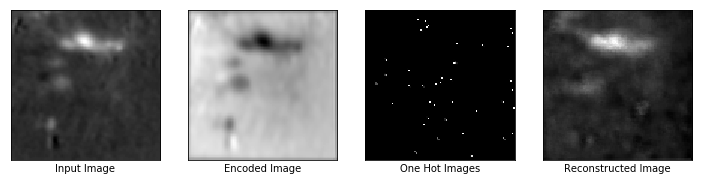

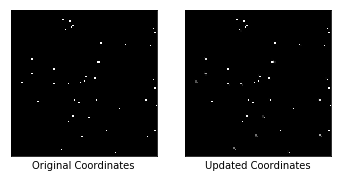

Epochs: 22, Loss: 0.00267849606461823
Similarity scores: [ 2.2616177   3.4492118   1.8678138   1.0984795  -0.41075188  2.0980039
  2.5775213   2.632561    1.7296711   1.394889    0.48286808  0.5409654
  2.16515     2.5778348   2.4993823   0.9711093   1.9310751   3.4393039
  3.7175004   2.6200538   2.9340954   2.5215907   2.1429813   0.1592502
  3.1785574   2.3912928   0.5831595   1.2432188   0.43097162  3.2081084
  1.1123291  -1.8372431   1.5350205   1.4696034   1.7436874   2.9141312
  1.6364192   0.45326746  2.9693146   2.1729121 ]
Updated Coordinates: [[[0.6564567 0.828342 ]]]
Gradient min:-0.001998085295781493, max:0.0015340327518060803



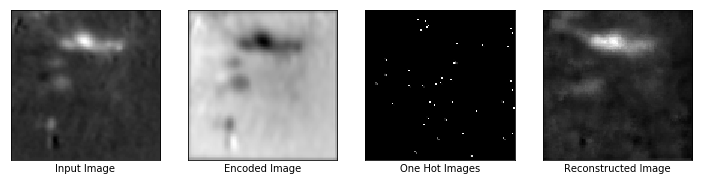

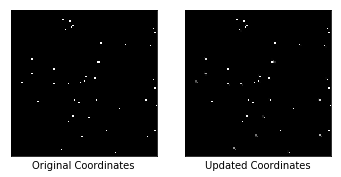

Epochs: 23, Loss: 0.0025984086096286774
Similarity scores: [ 2.5355093   3.5180185   1.8973271   1.8946179  -0.44121927  2.302336
  2.781274    3.0632343   1.677063    1.2947131   0.53012633  0.6078877
  2.049466    2.7636466   2.6651292   1.2940507   2.2133265   3.4585664
  4.092734    2.8350894   3.1742966   2.4799109   2.4049551   0.21438684
  3.3515809   2.4242225   1.1777986   1.3642662   0.4766043   3.2787142
  1.2642758  -1.9309047   1.6536479   1.5979432   1.9370611   3.2514107
  1.5718108   1.3434372   3.2336621   2.5054352 ]
Updated Coordinates: [[[0.6564215 0.8283567]]]
Gradient min:-0.0012791997287422419, max:0.0009727158467285335



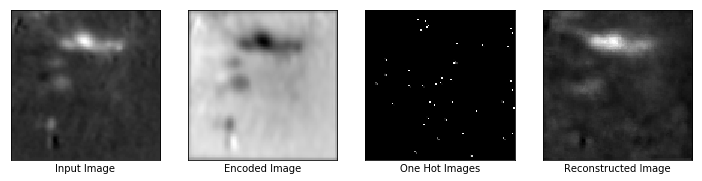

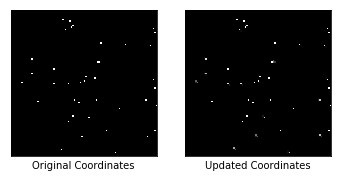

Epochs: 24, Loss: 0.002547977026551962
Similarity scores: [ 2.5935996   3.5405247   1.9267129   2.1960416  -0.45891458  2.343209
  2.8398192   3.2040339   1.7223597   1.3009306   0.5506578   0.7192092
  2.0573058   2.8167222   2.8413992   1.4008542   2.3261507   3.4753473
  4.0838842   2.8829703   3.210387    2.5335944   2.650727    0.3379305
  3.3493614   2.6870341   1.4597346   1.4422586   0.56402814  3.2524762
  1.3822203  -1.9054885   1.7120359   1.6654772   2.002794    3.3275244
  1.6107606   1.6673301   3.2648735   2.6735208 ]
Updated Coordinates: [[[0.65634674 0.82839316]]]
Gradient min:-0.0009083400364033878, max:0.0009916141862049699



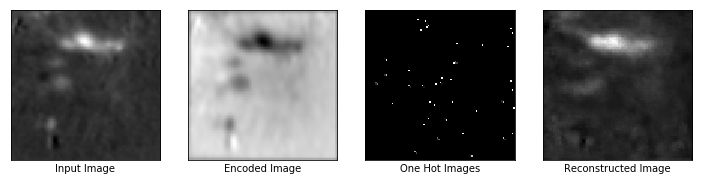

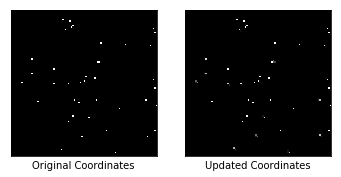

Epochs: 25, Loss: 0.0026119896210730076
Similarity scores: [ 2.5764263   3.4105415   1.884951    2.329864   -0.4759667   2.3077826
  2.7997549   3.3272116   1.7826868   1.2986296   0.54536295  0.82855606
  2.0512536   2.770677    3.062354    1.479365    2.4088373   3.3432012
  3.916206    2.8153608   3.115851    2.5813632   2.9410353   0.44916707
  3.2219906   3.0179727   1.7644339   1.4821532   0.6531574   3.1068017
  1.4478407  -1.8849857   1.7184768   1.6933428   2.0237796   3.3261945
  1.6486896   1.8882563   3.1782215   2.832797  ]
Updated Coordinates: [[[0.6562653 0.8284344]]]
Gradient min:-0.0008788506384007633, max:0.0011231667594984174



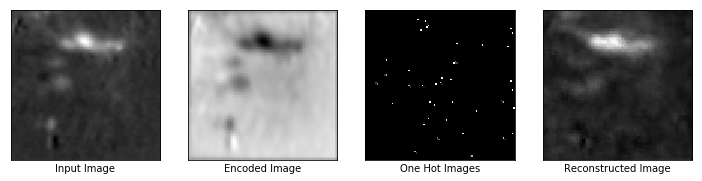

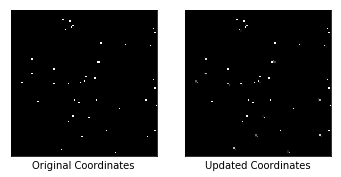

Epochs: 26, Loss: 0.0025571025907993317
Similarity scores: [ 2.747597    3.039346    1.6732744   2.5810413  -0.51060337  2.3867192
  2.7914407   3.6702707   1.6132693   1.0830854   0.44884747  0.89414424
  1.7762371   2.735401    3.3642702   1.6189867   2.6184032   2.9299376
  3.8663101   2.808001    3.0831254   2.3652108   3.157152    0.55038774
  2.9042609   3.2372184   1.932536    1.5043336   0.71102464  2.5676508
  1.5072501  -1.8511715   1.7092127   1.7174885   2.1202958   3.5527632
  1.4646838   2.017173    3.2372046   3.0915995 ]
Updated Coordinates: [[[0.65619403 0.8284428 ]]]
Gradient min:-0.001142085064202547, max:0.0011119445553049445



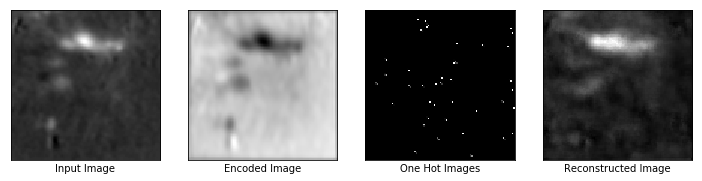

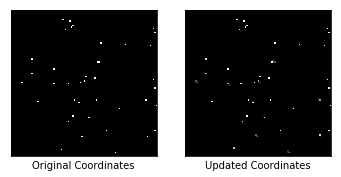

Epochs: 27, Loss: 0.0027030804194509983
Similarity scores: [ 2.8565345   2.5843606   1.4302146   2.553424   -0.5582752   2.425478
  2.7913787   3.9498105   1.5301226   0.96049446  0.31758133  0.97583133
  1.6080259   2.7054012   3.6837413   1.7072178   2.794999    2.5591025
  3.799014    2.774366    3.025348    2.2711017   3.4801357   0.7444033
  2.5890768   3.6007435   1.9399555   1.5351173   0.7946477   2.023702
  1.5806549  -1.8119977   1.7049649   1.7543066   2.2010593   3.6985495
  1.3786321   1.8360564   3.2428184   3.3513544 ]
Updated Coordinates: [[[0.6560769  0.82849836]]]
Gradient min:-0.001502780127339065, max:0.0015944417100399733



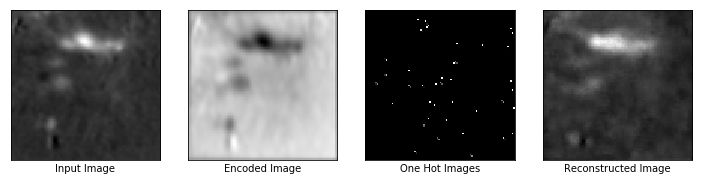

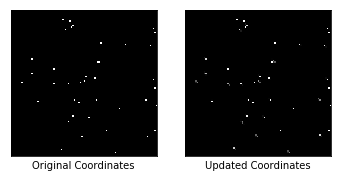

Epochs: 28, Loss: 0.002627023495733738
Similarity scores: [ 2.8440945   2.5667982   1.3751781   2.2316153  -0.55178314  2.4124243
  2.7922406   3.9190688   1.4882982   0.9046384   0.28632084  0.93061876
  1.5315536   2.6953447   3.6442728   1.6315284   2.7664974   2.479985
  3.8856905   2.7653406   3.019949    2.2059731   3.4309237   0.7746886
  2.6078877   3.5749693   1.4307123   1.5121444   0.75896406  1.9994867
  1.5604336  -1.7859204   1.6847211   1.7514586   2.1840587   3.7048433
  1.3334824   1.3513799   3.2309818   3.3017855 ]
Updated Coordinates: [[[0.65594697 0.8285078 ]]]
Gradient min:-0.0014880988746881485, max:0.0016243145801126957



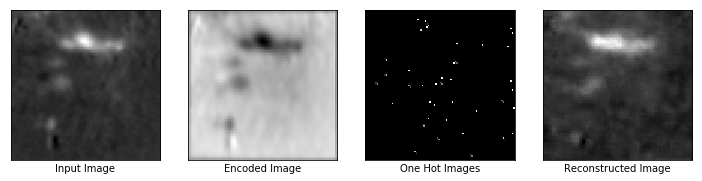

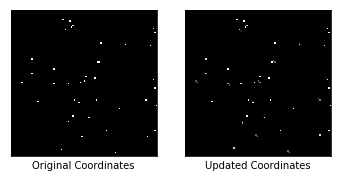

Epochs: 29, Loss: 0.0025531987193971872
Similarity scores: [ 2.6499577   2.9554553   1.717857    1.3943212  -0.22691074  2.3185477
  2.7449007   3.5078998   1.6911317   1.134096    0.62572443  1.0465857
  1.7853247   2.6873791   3.3735456   1.3535172   2.529357    2.8257344
  3.899581    2.739922    2.990472    2.3692474   3.1499624   0.904082
  3.0699003   3.4048805   0.74553335  1.5425644   0.902174    2.840828
  1.5319492  -1.5302248   1.7308024   1.7764918   2.0892239   3.4112606
  1.5452569   0.5729266   3.1115377   2.9713385 ]
Updated Coordinates: [[[0.6558365  0.82856804]]]
Gradient min:-0.0018540954915806651, max:0.0015525611815974116



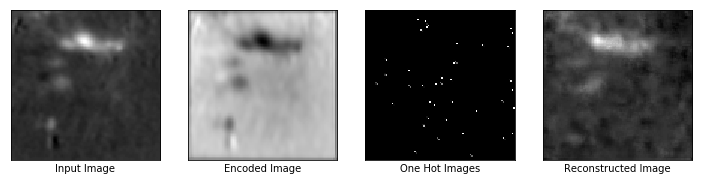

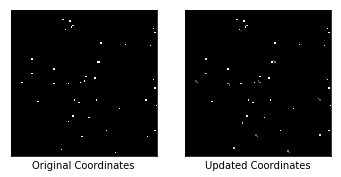

Epochs: 30, Loss: 0.00663403794169426
Similarity scores: [ 2.1910253   2.9554832   1.9612093   0.4032891   0.4909694   1.9930872
  2.424797    2.8733377   2.1889331   1.7586912   1.0180194   1.3853925
  2.3593116   2.4202118   3.0949848   0.956097    2.209766    2.959657
  3.0813558   2.3436937   2.511248    2.799338    3.222484    1.589152
  2.8234022   3.6476526   0.28750768  1.6824726   1.333799    2.823881
  1.6464932  -0.57559496  1.789573    1.8214743   1.915516    2.661654
  2.062504    0.1890471   2.5263088   2.64905   ]
Updated Coordinates: [[[0.6558456 0.8284922]]]
Gradient min:-0.005569229833781719, max:0.005257668439298868



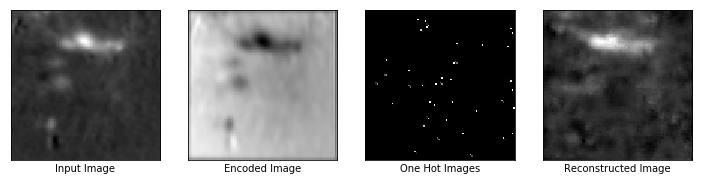

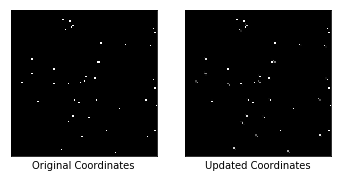

Epochs: 31, Loss: 0.0035918846260756254
Similarity scores: [ 1.964041    3.5713704   2.1128669  -0.22439596  0.36338273  1.9443122
  2.5276868   2.1828017   1.7138587   1.3758296   1.2160814   0.8037573
  1.9912195   2.5628753   2.2657373   0.8147011   1.7102934   3.4585297
  3.7475731   2.606995    2.8821104   2.375614    1.9134492   0.5559484
  3.4963148   2.5707266  -0.835593    1.4103554   0.7161603   3.5745685
  1.2511382  -1.1943046   1.6650379   1.6161816   1.6772454   2.5004041
  1.6147264  -0.6055469   2.718127    1.7847263 ]
Updated Coordinates: [[[0.6558983 0.8284421]]]
Gradient min:-0.0033888607285916805, max:0.0033070978242903948



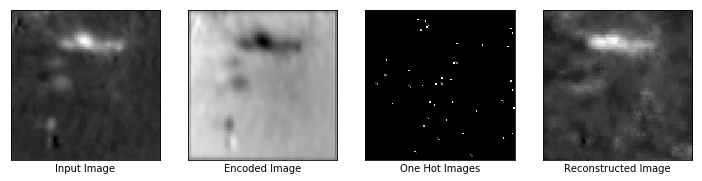

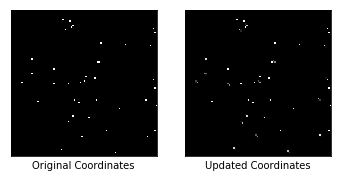

Epochs: 32, Loss: 0.0030315157491713762
Similarity scores: [ 1.8306736   3.8897219   2.2725272  -0.15079185  0.21475527  1.877214
  2.6297908   2.2346754   2.1843705   1.7097816   1.122642    0.9529368
  2.474094    2.67408     2.565444    1.0278558   1.7719721   3.8498032
  3.6584024   2.6209424   2.85583     2.9564977   2.5511086   0.8370438
  3.6306674   3.1884346  -0.35858384  1.5254517   0.8585638   3.7774315
  1.3622323  -1.2830924   1.7729682   1.7292004   1.7030921   2.3884382
  2.056168   -0.40272826  2.6104054   1.9961452 ]
Updated Coordinates: [[[0.6558743 0.8284479]]]
Gradient min:-0.0025963783264160156, max:0.002474062144756317



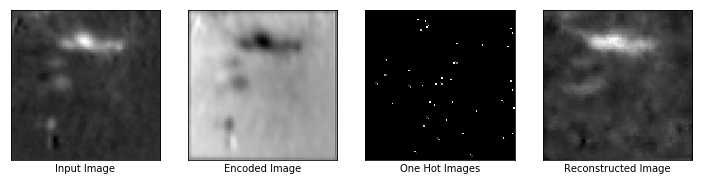

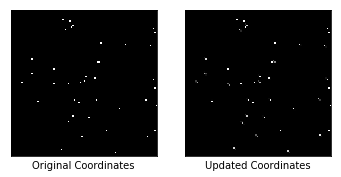

Epochs: 33, Loss: 0.003914140164852142
Similarity scores: [ 1.6998416   3.8566828   2.1985278  -0.35586938  0.08592082  1.7892671
  2.598257    2.027285    2.118935    1.6349717   0.95333725  0.87087613
  2.4176238   2.648807    2.4298306   0.9268046   1.6378342   3.8247142
  3.5974145   2.5852544   2.800222    2.923904    2.4470959   0.75826347
  3.60751     3.073481   -0.43649265  1.466299    0.78057396  3.7095623
  1.2942972  -1.3740228   1.7262976   1.6800246   1.62266     2.248578
  1.9915278  -0.51754063  2.5199673   1.8427495 ]
Updated Coordinates: [[[0.6558244  0.82847816]]]
Gradient min:-0.0038712958339601755, max:0.0037880081217736006



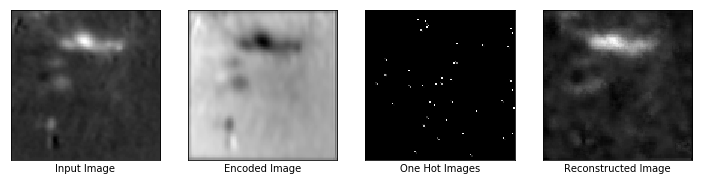

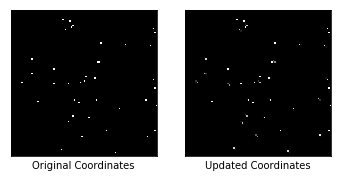

Epochs: 34, Loss: 0.0030135069973766804
Similarity scores: [ 1.9120213   4.1655955   2.347737   -0.19549704  0.10517374  1.9890628
  2.8623567   2.2987835   2.2444751   1.7248142   1.0218875   0.9290841
  2.550494    2.9114304   2.617686    1.1862979   1.8168162   4.1203775
  4.004427    2.8857586   3.099899    3.1045022   2.6922083   0.79962283
  3.9439056   3.253307   -0.3501932   1.5919576   0.8269734   4.004565
  1.4088696  -1.4761028   1.8859174   1.830929    1.7882463   2.5395527
  2.1082559  -0.4151544   2.8054223   2.0308526 ]
Updated Coordinates: [[[0.6557881  0.82848644]]]
Gradient min:-0.002850532764568925, max:0.0027503317687660456



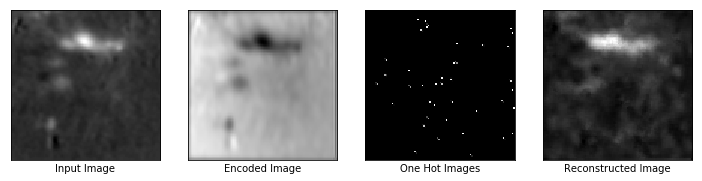

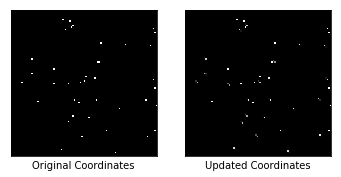

Epochs: 35, Loss: 0.002683668863028288
Similarity scores: [ 2.2236342   4.833433    2.735507   -0.60366035  0.380253    2.319149
  3.2657464   2.4590461   2.3669422   1.8853798   1.4171602   0.9571693
  2.741082    3.3359153   2.7122698   1.2219672   1.9603976   4.7360883
  4.787217    3.4061565   3.6710837   3.2676532   2.5561194   0.67803824
  4.6735783   3.2699225  -0.94171256  1.770919    0.8398692   4.761847
  1.5379769  -1.5702266   2.1439238   2.047224    2.0141978   2.9018493
  2.2356012  -0.8969584   3.3054843   2.043949  ]
Updated Coordinates: [[[0.6558032  0.82846093]]]
Gradient min:-0.0010696914978325367, max:0.0011240027379244566



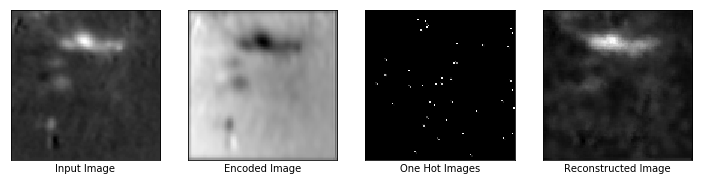

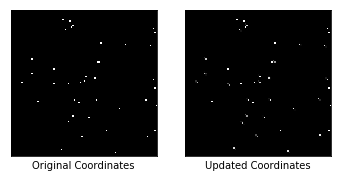

Epochs: 36, Loss: 0.0025890558026731014
Similarity scores: [ 2.4078      5.5272627   3.1270883  -0.3886278   0.54093105  2.5547507
  3.6173103   2.5317192   2.6264207   2.143629    1.7620156   1.0027559
  3.0433218   3.7024472   2.55089     1.186349    2.062524    5.4125104
  5.4227715   3.844432    4.138019    3.580037    2.5716608   0.6041606
  5.34318     3.0925314  -0.7319717   1.9439172   0.86355346  5.512828
  1.66335    -1.7026114   2.379637    2.2534158   2.1871426   3.1208096
  2.4971287  -0.7027762   3.6624024   2.043963  ]
Updated Coordinates: [[[0.65585065 0.8284167 ]]]
Gradient min:-0.0011258871527388692, max:0.0010471594287082553



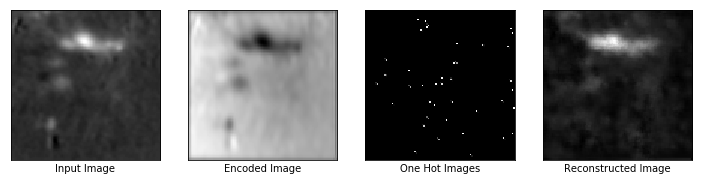

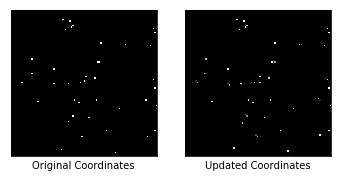

Epochs: 37, Loss: 0.0025033403653651476
Similarity scores: [ 2.6486096   5.5799346   3.0872993   0.03831497  0.57125866  2.7365284
  3.7970185   2.855484    2.5512354   2.058912    1.7428703   0.988261
  2.9386718   3.8548892   2.6108396   1.2506242   2.2586236   5.438411
  5.749846    4.06666     4.3675904   3.5022163   2.7261758   0.6217751
  5.48921     3.0672307  -0.48962712  2.0012295   0.8555393   5.5784507
  1.7407871  -1.8243506   2.4574594   2.341522    2.3220708   3.4410553
  2.427024   -0.36693427  3.9018395   2.25206   ]
Updated Coordinates: [[[0.65590554 0.8283607 ]]]
Gradient min:-0.002075976226478815, max:0.0022260374389588833



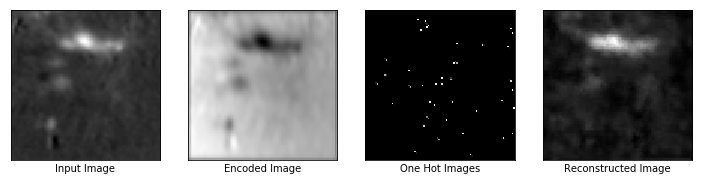

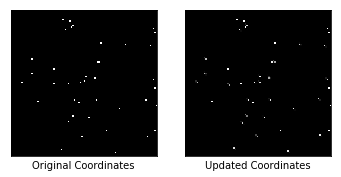

Epochs: 38, Loss: 0.0028833262622356415
Similarity scores: [ 2.7557476   5.4213886   2.9637728   0.30502364  0.62405497  2.7955945
  3.814371    2.988631    2.4084477   1.9343956   1.6980165   0.9595465
  2.763287    3.8536828   2.5888174   1.2134128   2.3311377   5.2620263
  5.8116646   4.1134276   4.4054327   3.321291    2.717629    0.6283358
  5.42431     2.9986465  -0.46224535  1.9937575   0.8373841   5.4310927
  1.7550024  -1.7739708   2.4492247   2.3445928   2.3573406   3.5802758
  2.296253   -0.1974563   3.9653013   2.3130345 ]
Updated Coordinates: [[[0.6559767 0.8282925]]]
Gradient min:-0.0035000259522348642, max:0.00374095281586051



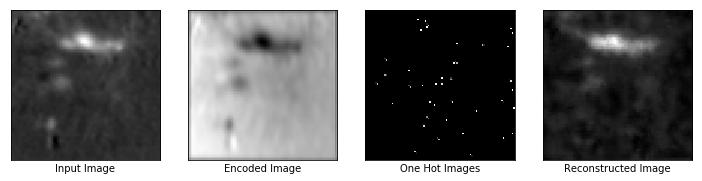

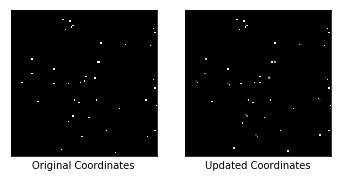

Epochs: 39, Loss: 0.003350958926603198
Similarity scores: [ 2.7724786   5.212946    2.8363795   0.46415904  0.64820355  2.7900705
  3.7783468   3.03879     2.331753    1.8640052   1.6373032   0.9677893
  2.6456718   3.7979445   2.6280046   1.1992474   2.3635159   5.053616
  5.7261705   4.0797586   4.3490853   3.1942747   2.7649462   0.68141323
  5.265667    3.0500345  -0.42210296  1.9872979   0.85692126  5.2113676
  1.7754456  -1.6481867   2.427422    2.3397114   2.357115    3.5981073
  2.2287254  -0.07961331  3.920048    2.358245  ]
Updated Coordinates: [[[0.656041   0.82823104]]]
Gradient min:-0.004154913127422333, max:0.004506888333708048



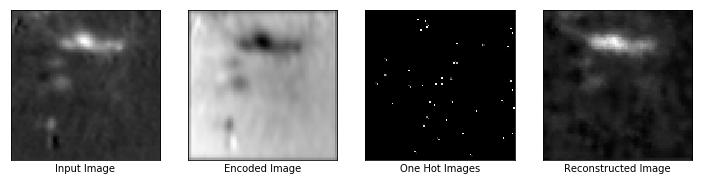

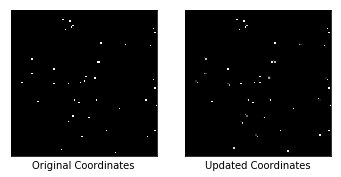

Epochs: 40, Loss: 0.003389761783182621
Similarity scores: [ 2.8551989   4.982189    2.6811228   0.7857441   0.53406256  2.8153322
  3.8085747   3.302787    2.301868    1.7728405   1.4766976   1.0261532
  2.560733    3.8063958   2.9222517   1.2769963   2.5231783   4.8363395
  5.6574745   4.0789857   4.3142138   3.1683943   3.143838    0.83115757
  5.0875134   3.4191527  -0.23329823  2.0249813   0.92360044  4.911355
  1.8548654  -1.5895767   2.4382894   2.3877609   2.4240255   3.716473
  2.1875994   0.14669545  3.916853    2.6266103 ]
Updated Coordinates: [[[0.6560832  0.82819015]]]
Gradient min:-0.004041794687509537, max:0.004482257645577192



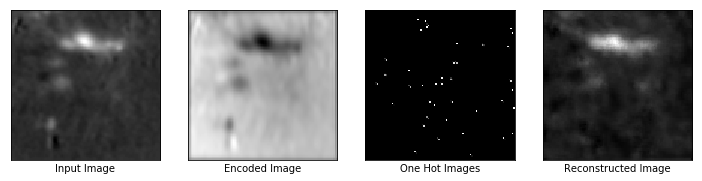

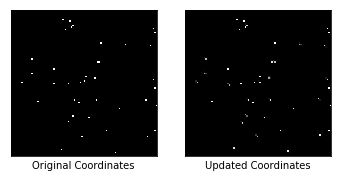

Epochs: 41, Loss: 0.003675074316561222
Similarity scores: [ 2.9367063   4.5184865   2.4267993   1.227352    0.3558789   2.8070242
  3.7521412   3.642435    2.2307816   1.6356634   1.256522    1.1136783
  2.4029927   3.7173321   3.3260355   1.4324104   2.7255225   4.404118
  5.405982    3.9736125   4.152703    3.0667498   3.628686    1.0627415
  4.675666    3.8530421   0.15983099  2.03504     1.0188153   4.359461
  1.9294025  -1.5302576   2.4010403   2.4007869   2.486528    3.833434
  2.1060991   0.49494877  3.831883    2.9960375 ]
Updated Coordinates: [[[0.6561014 0.828173 ]]]
Gradient min:-0.0042702495120465755, max:0.004703869111835957



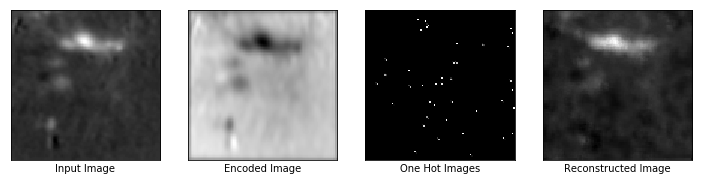

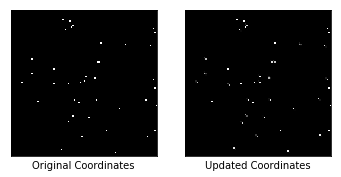

Epochs: 42, Loss: 0.004118021577596664
Similarity scores: [ 3.0244672  3.8877978  2.0958397  2.0764792  0.1444763  2.7767198
  3.63548    4.0585933  2.0739222  1.4135662  0.9732075  1.1987295
  2.1380155  3.565725   3.786882   1.7498413  2.9629583  3.7941108
  5.0514746  3.8052335  3.9152071  2.8757503  4.1660914  1.3411885
  4.113913   4.289285   0.7677998  2.0132408  1.1155789  3.6353958
  1.9828521 -1.4975148  2.3208559  2.3809474  2.538956   3.9612126
  1.9400429  1.0945408  3.707551   3.4426374]
Updated Coordinates: [[[0.6560877  0.82818294]]]
Gradient min:-0.004507339093834162, max:0.004914416931569576



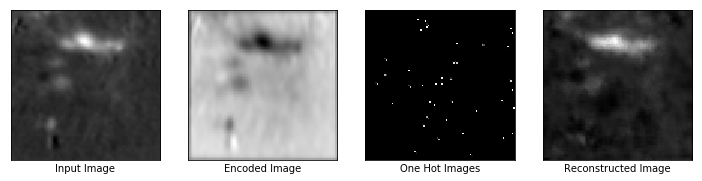

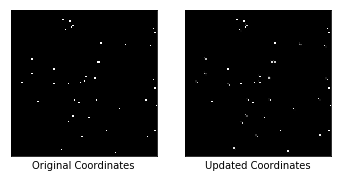

Epochs: 43, Loss: 0.004365375731140375
Similarity scores: [ 3.1648543   3.3476005   1.825931    2.8051744   0.01877356  2.8048863
  3.5538797   4.46457     1.9061279   1.2143018   0.77736133  1.2693074
  1.8665894   3.4504783   4.180982    2.096542    3.2037838   3.2555254
  4.820624    3.69935     3.7646308   2.6626437   4.5707235   1.5546279
  3.6572113   4.614724    1.3063921   2.000206    1.1943094   3.0361063
  2.0362916  -1.42403     2.2616313   2.3716424   2.6132002   4.1538053
  1.7702833   1.7538909   3.670064    3.8428078 ]
Updated Coordinates: [[[0.6560622 0.8282036]]]
Gradient min:-0.004581412300467491, max:0.004937231540679932



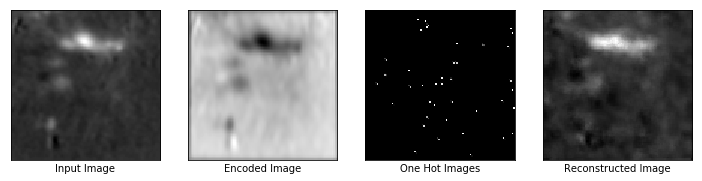

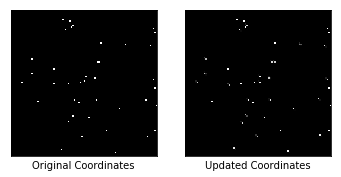

Epochs: 44, Loss: 0.004183206707239151
Similarity scores: [ 3.2542377   3.1211932   1.7311804   3.2949586  -0.03450793  2.8352592
  3.5459263   4.700002    1.8657444   1.1536057   0.706511    1.3276893
  1.775794    3.424568    4.442231    2.2946293   3.3609781   3.0415115
  4.7145696   3.678523    3.7074943   2.6099997   4.7961807   1.6896133
  3.4455469   4.8692937   1.4333212   2.0321898   1.2584593   2.763984
  2.0955336  -1.3893642   2.2677643   2.406362    2.6791828   4.2817817
  1.7288138   2.0933661   3.6603796   4.0752115 ]
Updated Coordinates: [[[0.65603155 0.8282292 ]]]
Gradient min:-0.004371183458715677, max:0.004772043786942959



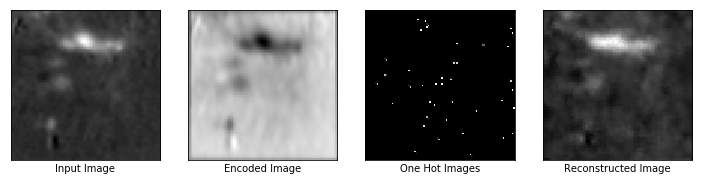

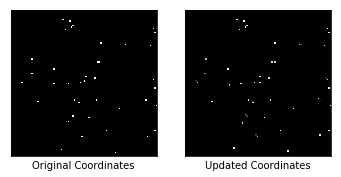

Epochs: 45, Loss: 0.0038984413258731365
Similarity scores: [ 3.197882    3.074629    1.7142719   3.2745006  -0.06854716  2.787777
  3.5012918   4.6290126   1.8440918   1.1220944   0.70203024  1.3028598
  1.7280126   3.3801188   4.4161267   2.2989874   3.319784    2.9940014
  4.640169    3.6413262   3.6508625   2.586564    4.733797    1.6542052
  3.377027    4.933286    1.1634874   2.0109494   1.2289822   2.703503
  2.0671716  -1.3999286   2.2401633   2.3843753   2.6446106   4.2353983
  1.7084807   1.9187192   3.596803    4.01358   ]
Updated Coordinates: [[[0.6559972  0.82825714]]]
Gradient min:-0.004052022937685251, max:0.004473628010600805



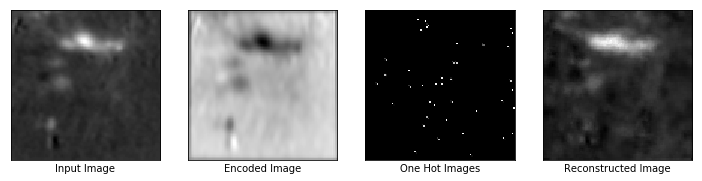

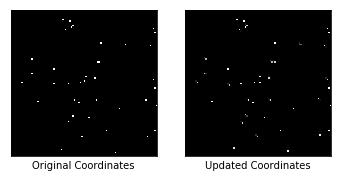

Epochs: 46, Loss: 0.0036725501995533705
Similarity scores: [ 3.1439834   3.2195566   1.7793405   3.1471224  -0.07620345  2.7675133
  3.5414405   4.5528765   1.935258    1.1828269   0.71479535  1.3013765
  1.8205746   3.4261093   4.416313    2.2265491   3.2896073   3.1576502
  4.6506515   3.6733747   3.6654966   2.706378    4.7597404   1.6685077
  3.464259    5.054245    0.8944401   2.03957     1.2239454   2.82706
  2.0854566  -1.4162791   2.2750125   2.4168174   2.6389558   4.1821094
  1.7962694   1.6822157   3.567118    3.9754188 ]
Updated Coordinates: [[[0.65598345 0.828266  ]]]
Gradient min:-0.003777523059397936, max:0.004191177897155285



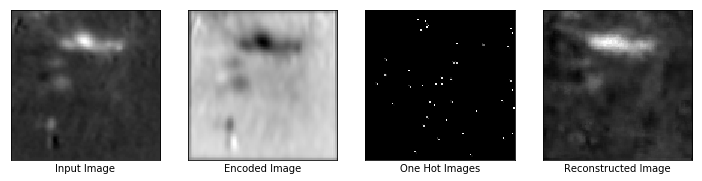

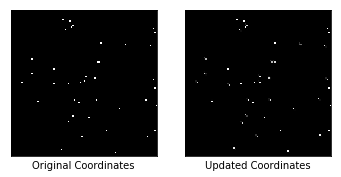

Epochs: 47, Loss: 0.0037025688216090202
Similarity scores: [ 3.166298    3.3130891   1.8083984   3.080701   -0.04374306  2.816439
  3.5927968   4.5058236   1.9046916   1.1394882   0.7615164   1.2446439
  1.7543632   3.4754386   4.3307652   2.1642547   3.2659166   3.230123
  4.8037996   3.7622678   3.7648768   2.6625998   4.6006227   1.5677003
  3.576066    4.969426    0.6589572   2.0361767   1.1683136   2.9346738
  2.072995   -1.4337368   2.2910876   2.4263065   2.6433122   4.228572
  1.768088    1.5087699   3.6583698   3.8897188 ]
Updated Coordinates: [[[0.655975  0.8282705]]]
Gradient min:-0.003649656195193529, max:0.004091635812073946



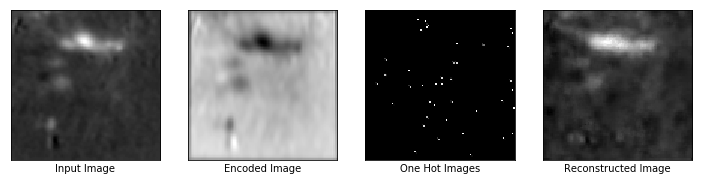

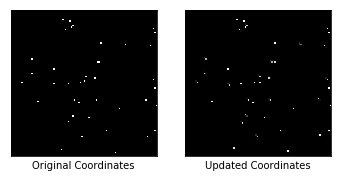

Epochs: 48, Loss: 0.0036996635608375072
Similarity scores: [ 3.2551639e+00  3.4101930e+00  1.8299174e+00  2.8464220e+00
  3.9675557e-03  2.9163442e+00  3.6736722e+00  4.5208530e+00
  1.7995678e+00  1.0438153e+00  8.1511801e-01  1.1777530e+00
  1.6251690e+00  3.5509460e+00  4.2722750e+00  2.0735521e+00
  3.2708673e+00  3.2846603e+00  5.0690932e+00  3.8986862e+00
  3.9317999e+00  2.5372765e+00  4.3992739e+00  1.4445003e+00
  3.7323508e+00  4.8228431e+00  3.8794693e-01  2.0238400e+00
  1.0917429e+00  3.0710745e+00  2.0575354e+00 -1.5044247e+00
  2.3104403e+00  2.4352801e+00  2.6715577e+00  4.3592944e+00
  1.6731476e+00  1.3206211e+00  3.8381541e+00  3.8266375e+00]
Updated Coordinates: [[[0.6559744 0.8282663]]]
Gradient min:-0.0035749475937336683, max:0.004131604917347431



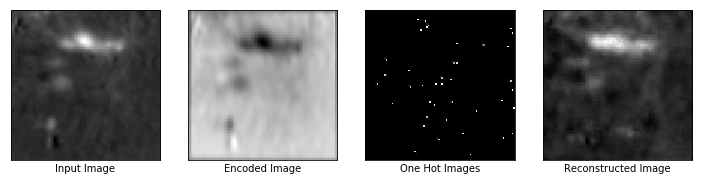

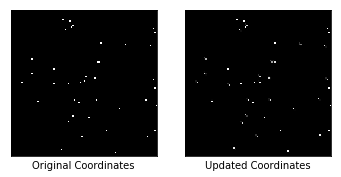

Epochs: 49, Loss: 0.0036650977563112974
Similarity scores: [ 3.4987886   3.4732366   1.8326569   2.5562596   0.02764045  3.1184547
  3.8494005   4.7880177   1.7014165   0.95452696  0.8316598   1.1546062
  1.5154109   3.7111495   4.3509464   1.9321715   3.4311764   3.3095174
  5.421574    4.114426    4.176768    2.4314423   4.393835    1.4146128
  3.8943253   4.7499022   0.14724393  2.0657184   1.0710181   3.1569688
  2.1132343  -1.5824217   2.3855848   2.512475    2.8044407   4.6882443
  1.5810511   1.1109233   4.130203    3.9701428 ]
Updated Coordinates: [[[0.65597194 0.8282648 ]]]
Gradient min:-0.003528216388076544, max:0.004110036883503199



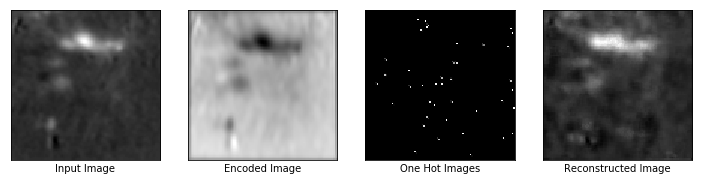

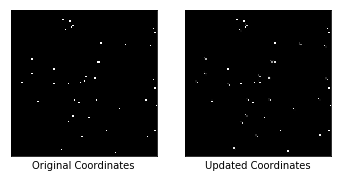

Epochs: 50, Loss: 0.00367284775711596
Similarity scores: [ 3.5039208   3.3970459   1.7487007   2.0172496  -0.01073425  3.1035323
  3.8235767   4.819006    1.5609676   0.8480996   0.76193213  1.0801504
  1.3937274   3.682557    4.397426    1.8066559   3.4245164   3.2074718
  5.4290094   4.0959086   4.162015    2.2784357   4.340481    1.3708943
  3.8561096   4.7178454  -0.09982777  1.9975214   1.0095409   3.0907488
  2.0610504  -1.674858    2.3347845   2.461824    2.7793486   4.7131214
  1.4498682   0.8019768   4.132948    3.973404  ]
Updated Coordinates: [[[0.6559607  0.82826996]]]
Gradient min:-0.0034549038391560316, max:0.004021200817078352



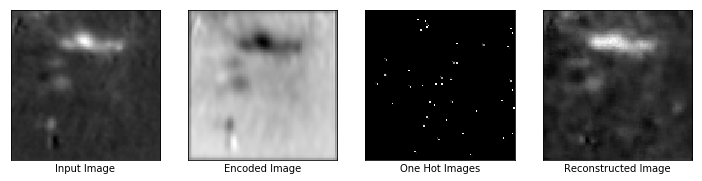

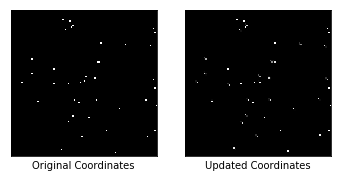

Epochs: 51, Loss: 0.0036839069798588753
Similarity scores: [ 3.4010317   3.463317    1.787692    1.4478203  -0.01001761  3.0295331
  3.7835832   4.6594987   1.55813     0.8718541   0.7705278   1.0387182
  1.4362696   3.6571908   4.2953987   1.6468471   3.3250477   3.2702997
  5.36563     4.051423    4.1086903   2.3017094   4.2412515   1.3233321
  3.8907995   4.6358504  -0.4043565   1.9694257   0.9747718   3.16009
  2.0187674  -1.7309961   2.318666    2.437257    2.720234    4.586817
  1.4498438   0.46144968  4.0491147   3.844766  ]
Updated Coordinates: [[[0.6559402 0.8282816]]]
Gradient min:-0.0033763847313821316, max:0.003897209884598851



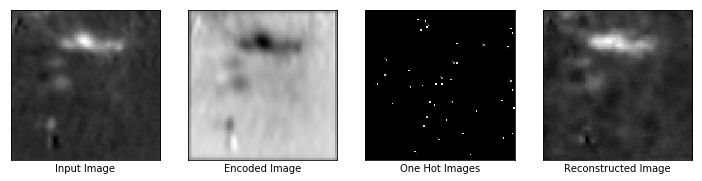

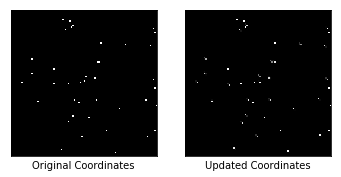

Epochs: 52, Loss: 0.0037007243372499943
Similarity scores: [ 3.1655748   3.3343363   1.7321129   1.1652123  -0.07489181  2.8220959
  3.625527    4.476988    1.7008687   0.97766054  0.6732398   1.0965
  1.5797408   3.5090203   4.402374    1.6391482   3.2218826   3.1966488
  4.936029    3.8285577   3.8270967   2.4747345   4.4865646   1.4742293
  3.6409047   4.94542    -0.36227643  1.9529417   1.0352528   2.9704623
  2.0176752  -1.650897    2.268507    2.4016008   2.6114771   4.2855268
  1.5859724   0.34614167  3.7199447   3.8248858 ]
Updated Coordinates: [[[0.6559464 0.8282733]]]
Gradient min:-0.003561012912541628, max:0.004050231538712978



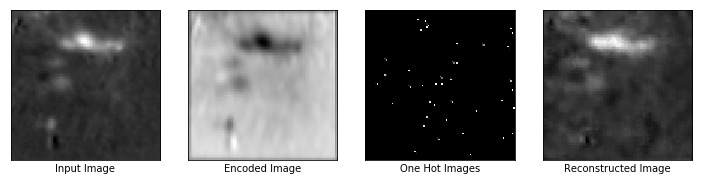

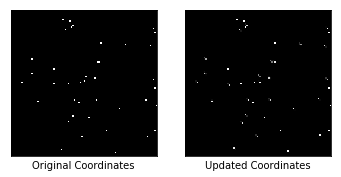

Epochs: 53, Loss: 0.004080032929778099
Similarity scores: [ 3.26557     3.211215    1.7045436   1.1398965   0.01425082  2.8899715
  3.6417146   4.583446    1.6382033   0.94758433  0.686389    1.1365979
  1.5178404   3.5244946   4.456343    1.6620681   3.2848432   3.064568
  4.9206905   3.8333216   3.834539    2.3841603   4.4490814   1.5147746
  3.5567544   4.9386964  -0.5370541   1.9900733   1.0766122   2.8534136
  2.06905    -1.5061322   2.304361    2.4447598   2.6719084   4.3676805
  1.5282536   0.28819954  3.776163    3.894709  ]
Updated Coordinates: [[[0.6560088 0.8282218]]]
Gradient min:-0.0036634912248700857, max:0.004150599241256714



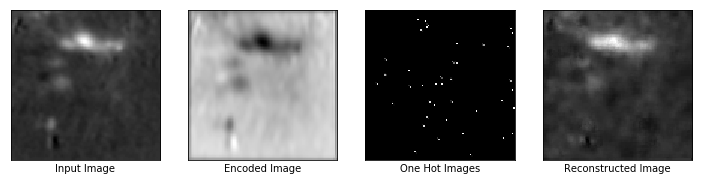

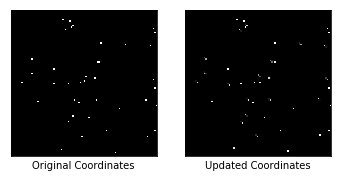

Epochs: 54, Loss: 0.004232220351696014
Similarity scores: [ 3.3188527   3.3482556   1.8188963   1.1160711   0.11627655  2.9549766
  3.725218    4.6100097   1.7641981   1.0874529   0.77838445  1.2150182
  1.6711137   3.6101997   4.496588    1.6687353   3.3228276   3.2190382
  5.0001564   3.9135249   3.9146314   2.5165026   4.500867    1.578407
  3.664905    5.0161166  -0.48150307  2.0715125   1.1496407   2.992171
  2.1464882  -1.4018134   2.3934875   2.5265288   2.7267604   4.4115634
  1.6524483   0.31225792  3.8429205   3.923703  ]
Updated Coordinates: [[[0.65607613 0.82816523]]]
Gradient min:-0.0035093827173113823, max:0.004098780453205109



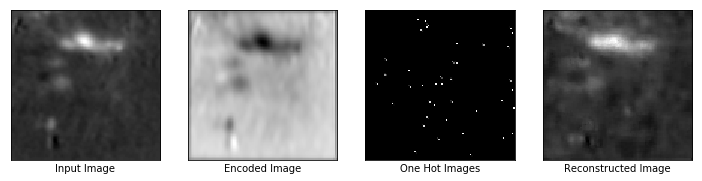

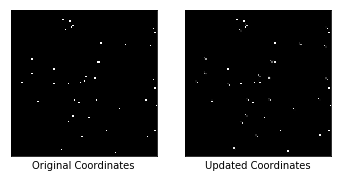

Epochs: 55, Loss: 0.0041284444741904736
Similarity scores: [ 3.5198197   3.3231447   1.8212458   1.2213187   0.14936775  3.0996718
  3.8363438   4.882662    1.7234267   1.0873897   0.78144646  1.2491177
  1.667075    3.7002146   4.6732025   1.7477218   3.4992518   3.1932242
  5.153495    4.0284896   4.0323563   2.4908779   4.581503    1.6109159
  3.6862235   5.0391207  -0.5131667   2.1263497   1.1943959   2.9564743
  2.2192411  -1.3921689   2.4593675   2.6017735   2.8465412   4.680251
  1.620701    0.33887807  4.0224423   4.1220117 ]
Updated Coordinates: [[[0.65612733 0.8281207 ]]]
Gradient min:-0.0032783562783151865, max:0.003930454142391682



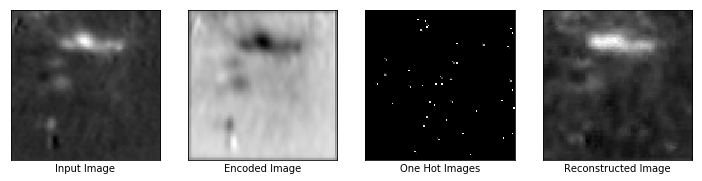

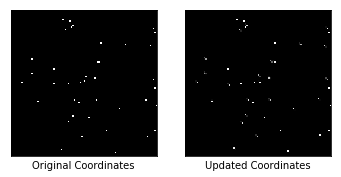

Epochs: 56, Loss: 0.003998471889644861
Similarity scores: [ 3.6305969   3.382877    1.8705145   1.1638579   0.17657295  3.189445
  3.9369442   5.0392513   1.729558    1.0984433   0.8324279   1.2697322
  1.6986551   3.789595    4.8011293   1.6973661   3.6119633   3.2554295
  5.31175     4.138112    4.1423464   2.5326757   4.689132    1.6361626
  3.7720377   5.0930057  -0.44186148  2.1715417   1.2214085   3.0125875
  2.2740583  -1.4271287   2.5160658   2.6678698   2.9340553   4.842528
  1.6317861   0.29781672  4.1416306   4.245473  ]
Updated Coordinates: [[[0.656163 0.828086]]]
Gradient min:-0.0033436384983360767, max:0.004051133990287781



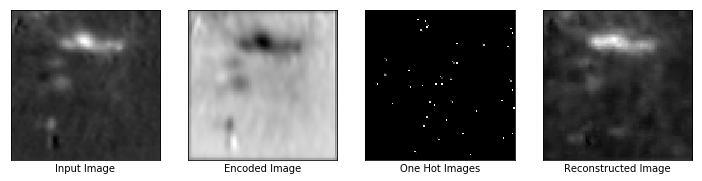

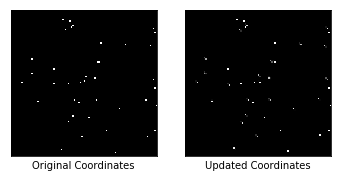

Epochs: 57, Loss: 0.003562687197700143
Similarity scores: [ 3.4360228   3.457463    1.8879106   0.93248427  0.07824633  3.0582423
  3.8796394   4.7672176   1.7640849   1.0701399   0.8208204   1.214145
  1.694677    3.7439978   4.6481013   1.7436873   3.4437587   3.3213665
  5.2329555   4.091277    4.066084    2.605577    4.5386314   1.5374378
  3.7970679   5.121349   -0.6801562   2.1219087   1.1433146   3.0586534
  2.188911   -1.5233479   2.4717298   2.6179378   2.828549    4.6244617
  1.6609927   0.08276904  4.0079646   4.0208387 ]
Updated Coordinates: [[[0.65616864 0.8280806 ]]]
Gradient min:-0.003402697155252099, max:0.004157907795161009



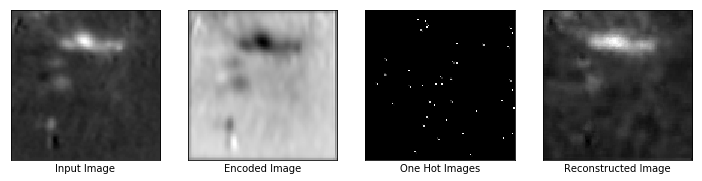

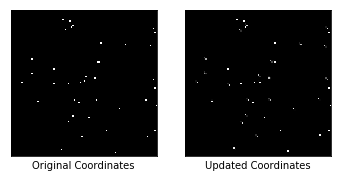

Epochs: 58, Loss: 0.0034361854195594788
Similarity scores: [ 3.2999704   3.2894104   1.7728074   0.84632665  0.00761273  2.944969
  3.7724946   4.5655537   1.6645702   0.9791333   0.72619617  1.144011
  1.583544    3.6395736   4.4853477   1.6129421   3.3032203   3.1373317
  5.0752025   3.980051    3.9417088   2.4852316   4.3612595   1.4888328
  3.6533084   4.948492   -0.8611535   2.0320618   1.0686381   2.8922465
  2.1001916  -1.6086651   2.3834271   2.531871    2.7260215   4.4560795
  1.5665404  -0.03597219  3.8876753   3.840515  ]
Updated Coordinates: [[[0.6561924 0.828061 ]]]
Gradient min:-0.0032643929589539766, max:0.003961505368351936



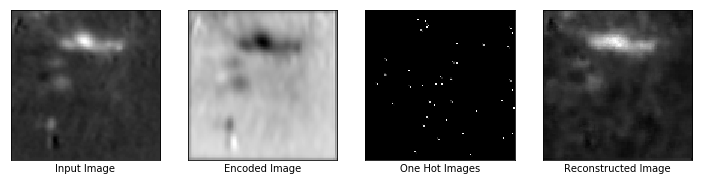

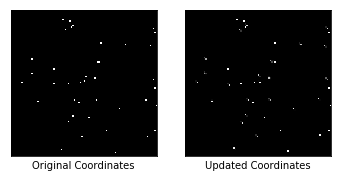

Epochs: 59, Loss: 0.0036126968916505575
Similarity scores: [ 3.4187489   3.2799783   1.7910773   1.2985768   0.08506519  3.046511
  3.847237    4.6953735   1.621369    0.9665706   0.7561499   1.1614355
  1.5670675   3.7151556   4.4171157   1.6365032   3.3957982   3.1123807
  5.150794    4.047783    4.016116    2.4267645   4.3728786   1.5400922
  3.6953676   4.6461415  -0.40496388  2.0757108   1.1083999   2.9024146
  2.1582568  -1.5612382   2.4367423   2.5927262   2.8133557   4.5672045
  1.5284536   0.4010023   4.0032406   3.9368865 ]
Updated Coordinates: [[[0.6562193 0.8280373]]]
Gradient min:-0.003294926369562745, max:0.004033131059259176



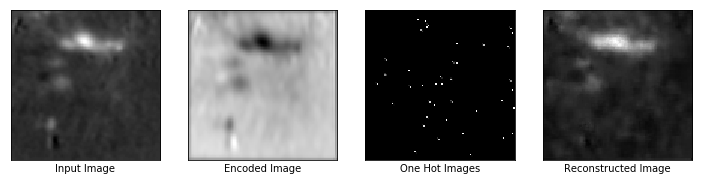

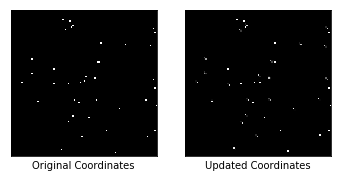

Epochs: 60, Loss: 0.0035563705023378134
Similarity scores: [ 3.355679    3.6226952   2.0192318   1.5459841   0.1882911   3.0668852
  3.9649425   4.475242    1.833244    1.16141     0.90374094  1.2341503
  1.8286217   3.8573375   4.250182    1.573901    3.297465    3.4653668
  5.3001523   4.1777415   4.1472664   2.6923702   4.336343    1.5297569
  3.992286    4.5868735  -0.27924222  2.1752694   1.1652504   3.2600095
  2.2122505  -1.5514338   2.5502465   2.683714    2.830798    4.461553
  1.7263396   0.56851196  4.0453954   3.7703795 ]
Updated Coordinates: [[[0.65624905 0.82801276]]]
Gradient min:-0.0031582145020365715, max:0.0039504352025687695



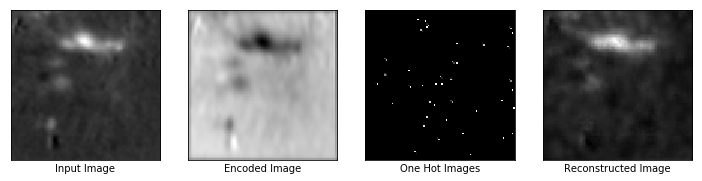

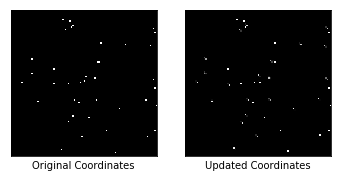

Epochs: 61, Loss: 0.0033757835626602173
Similarity scores: [ 3.2519531   4.135087    2.3572583   1.720006    0.31788468  3.0740824
  4.1135607   4.192852    2.182164    1.453896    1.13049     1.32804
  2.2035406   4.03427     4.043525    1.6377825   3.1934571   4.025883
  5.452666    4.343454    4.292336    3.1335232   4.255369    1.5106598
  4.3771267   4.545662   -0.2198568   2.3235993   1.2238393   3.7691603
  2.282636   -1.5617292   2.7111263   2.822312    2.8594866   4.309343
  2.057429    0.72248036  4.0739193   3.5573742 ]
Updated Coordinates: [[[0.656286 0.827985]]]
Gradient min:-0.003085334785282612, max:0.004005161114037037



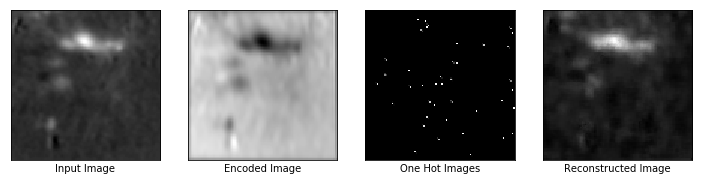

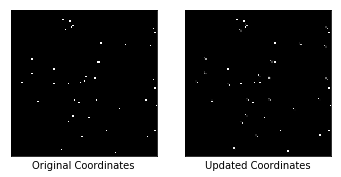

Epochs: 62, Loss: 0.0028808685019612312
Similarity scores: [ 3.1667945   4.5880356   2.6075943   1.5467476   0.48031893  3.0525022
  4.22887     3.9533217   2.3587542   1.6240257   1.2656282   1.3268733
  2.471125    4.1724744   3.837699    1.5105668   3.0597794   4.4804845
  5.624957    4.457313    4.411228    3.3958573   4.094465    1.4643376
  4.7397985   4.461039   -0.52852684  2.3916013   1.236887    4.2436204
  2.285331   -1.6571645   2.8030381   2.8815367   2.8459609   4.177546
  2.2314615   0.49196786  4.0895276   3.3460977 ]
Updated Coordinates: [[[0.656356   0.82791007]]]
Gradient min:-0.0027272263541817665, max:0.0036810385063290596



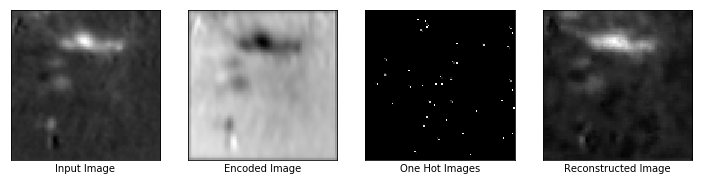

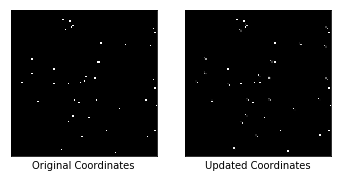

Epochs: 63, Loss: 0.003717768006026745
Similarity scores: [ 3.2305832   4.684102    2.6251464   1.7554387   0.49133673  3.0854776
  4.320626    4.0230293   2.373615    1.6530709   1.2059233   1.2886697
  2.5216804   4.2400055   3.7430794   1.5083388   3.0882192   4.5833573
  5.74838     4.5449386   4.498957    3.449359    4.088525    1.4878294
  4.808584    4.199675   -0.02780521  2.4146097   1.2227939   4.314143
  2.2990096  -1.6968601   2.8403814   2.9145389   2.8578808   4.271417
  2.2610378   0.8753653   4.143674    3.3541288 ]
Updated Coordinates: [[[0.65639967 0.8278734 ]]]
Gradient min:-0.003170470241457224, max:0.004352144431322813



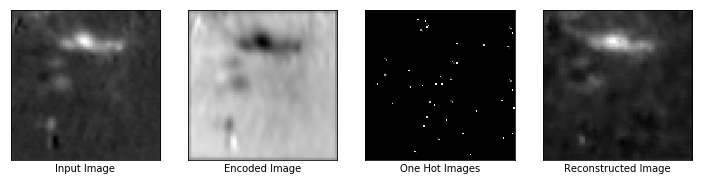

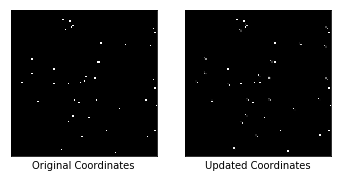

Epochs: 64, Loss: 0.0032699820585548878
Similarity scores: [ 3.3351846  4.6139474  2.6355808  2.3590484  0.4903963  3.1302571
  4.3579035  4.2724094  2.471758   1.7270327  1.1576725  1.3989848
  2.616922   4.2748723  3.9997451  1.7786362  3.2657068  4.5480957
  5.620974   4.5345907  4.4549947  3.55929    4.4609013  1.7181329
  4.7059207  4.3650126  0.7924267  2.5055895  1.3449253  4.199132
  2.4184446 -1.6240267  2.908136   3.0219233  2.9655101  4.3739657
  2.3474398  1.4618657  4.1290793  3.6302066]
Updated Coordinates: [[[0.65641624 0.8278445 ]]]
Gradient min:-0.0029813568107783794, max:0.004275230690836906



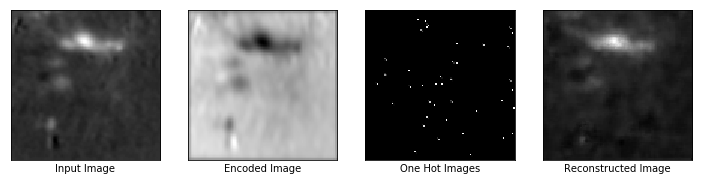

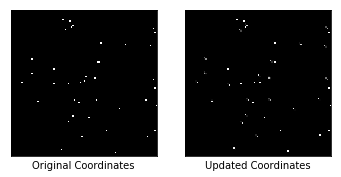

Epochs: 65, Loss: 0.00292998761869967
Similarity scores: [ 3.408978   4.9959106  2.8893015  2.560887   0.4930425  3.2659564
  4.61514    4.359486   2.6757596  1.8537611  1.2973565  1.5215598
  2.8473456  4.554475   4.189673   1.8326863  3.384447   4.9318852
  5.917731   4.816751   4.716411   3.8381417  4.7665358  1.7875148
  5.072596   4.554527   1.420026   2.673436   1.4314982  4.554452
  2.5589147 -1.7122662  3.1063268  3.2187076  3.1392055  4.447227
  2.531408   1.7614406  4.3125277  3.7479084]
Updated Coordinates: [[[0.65642756 0.8278177 ]]]
Gradient min:-0.0028027596417814493, max:0.004043609369546175



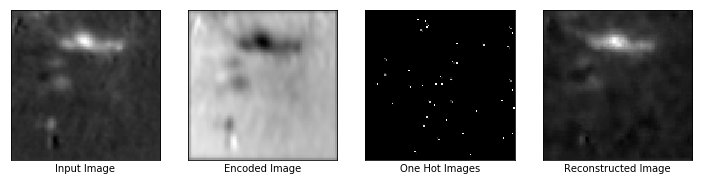

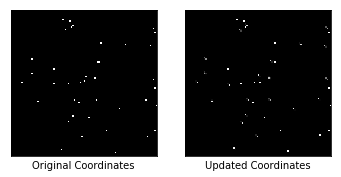

Epochs: 66, Loss: 0.0030925371684134007
Similarity scores: [ 3.5112195  5.5658875  3.2646065  2.754767   0.6980905  3.4607608
  4.889924   4.2450027  2.773201   1.9944003  1.6081092  1.5613015
  3.0272653  4.8772454  3.9343565  1.8085845  3.3727777  5.452351
  6.4593673  5.185065   5.1330957  3.997075   4.521928   1.6639316
  5.663903   4.2461724  1.4395999  2.8090909  1.4363263  5.1974015
  2.6243963 -1.8152097  3.3064535  3.3799605  3.2791498  4.5478578
  2.636828   1.7979449  4.6339736  3.561747 ]
Updated Coordinates: [[[0.65644985 0.8278019 ]]]
Gradient min:-0.0029577184468507767, max:0.0043894038535654545



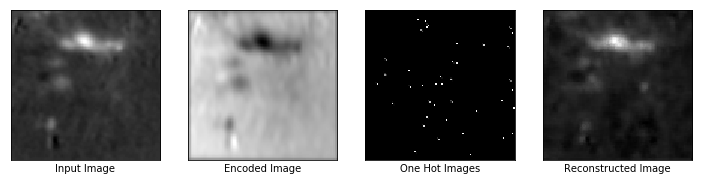

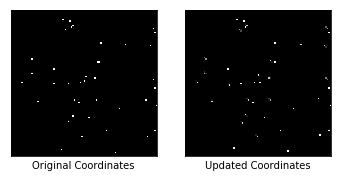

Epochs: 67, Loss: 0.003768129274249077
Similarity scores: [ 3.4273689  5.915389   3.5441563  2.5493655  0.7978717  3.488706
  4.9390597  3.8839588  2.8820615  2.0880504  1.9194082  1.5783895
  3.1235437  4.9647856  3.532518   1.6642187  3.1999087  5.7808948
  6.708101   5.340014   5.3041425  4.096029   4.071676   1.4201409
  5.9987125  3.9018192  1.4506605  2.8456628  1.3662552  5.61397
  2.5848713 -1.8366859  3.3658297  3.413433   3.2632995  4.4324536
  2.7411637  1.6892328  4.7297797  3.1698794]
Updated Coordinates: [[[0.65647364 0.82776403]]]
Gradient min:-0.0031495089642703533, max:0.004697402939200401



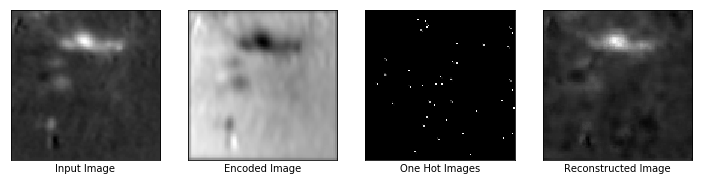

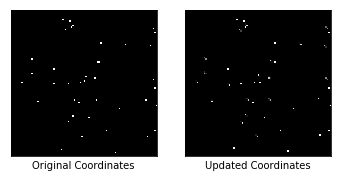

Epochs: 68, Loss: 0.006368067115545273
Similarity scores: [ 3.0689328  6.005289   3.6772838  1.889404   1.0582535  3.272126
  4.699395   3.1371422  2.8624284  2.193907   2.1867476  1.512487
  3.1505592  4.775066   2.8651624  1.3454078  2.7827013  5.8470125
  6.465185   5.14525    5.1366825  4.005971   3.3560925  1.2248082
  6.024595   3.3282113  1.066282   2.7630022  1.2804774  5.807008
  2.4396734 -1.5954139  3.263506   3.2859094  3.0383387  3.9116802
  2.7475326  1.2369318  4.4665766  2.525826 ]
Updated Coordinates: [[[0.6564844  0.82773685]]]
Gradient min:-0.003192676231265068, max:0.005003483034670353



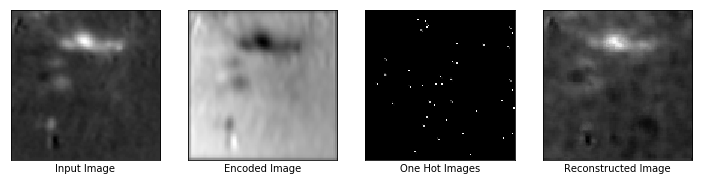

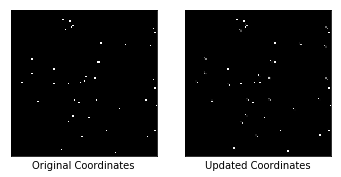

Epochs: 69, Loss: 0.005530731286853552
Similarity scores: [ 3.3099773   5.5111938   3.398688    1.739694    1.2353917   3.4327958
  4.6111107   3.2482944   2.2446446   1.711677    2.2381456   1.3179238
  2.4155977   4.654121    2.5354288   1.1529505   2.7938564   5.218545
  6.685369    5.160171    5.2421274   3.1870356   2.584844    0.81306285
  5.831036    2.5897458  -0.27647176  2.588475    1.1002213   5.444734
  2.313936   -1.3901615   3.1112514   3.1340337   3.0367057   4.197153
  2.171615    0.5406845   4.7133474   2.3672292 ]
Updated Coordinates: [[[0.656457   0.82771873]]]
Gradient min:-0.0026185389142483473, max:0.0038910554721951485



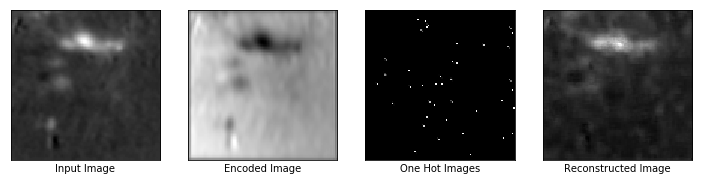

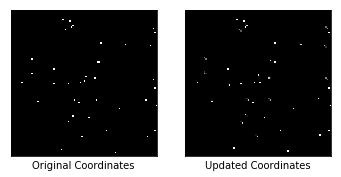

Epochs: 70, Loss: 0.0029454512987285852
Similarity scores: [ 3.4129436  6.120714   3.8047717  1.026492   1.2859714  3.6470563
  4.9113755  3.3077338  2.8033237  2.2213006  2.5419254  1.5870856
  3.053769   4.940093   2.7490823  1.1158537  2.9161122  5.942737
  7.169655   5.5252557  5.606606   3.8230581  2.9463859  1.0052382
  6.316836   3.1648831 -0.4256378  2.8464673  1.307787   6.023208
  2.5150273 -1.3761971  3.3876708  3.3870897  3.2392733  4.3295283
  2.7232995 -0.0370975  4.975653   2.4887733]
Updated Coordinates: [[[0.6563831  0.82775384]]]
Gradient min:-0.0014720996841788292, max:0.002286113565787673



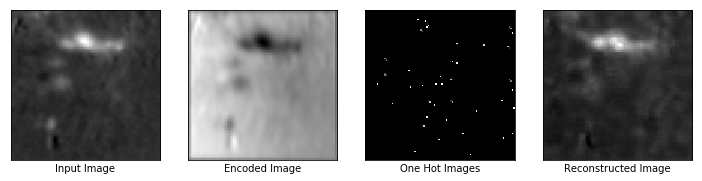

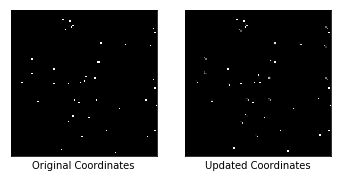

Epochs: 71, Loss: 0.0021860834676772356
Similarity scores: [ 3.0285146   7.40235     4.60396     0.19544397  1.4060354   3.5034158
  5.180725    2.6633754   3.7649667   3.0803554   2.9912505   1.7760328
  4.1953154   5.307293    2.4668875   0.62279356  2.5323746   7.3762727
  7.4744544   5.826958    5.8848324   4.979053    2.9609027   0.98997045
  7.246633    3.3413975  -0.8691478   3.1116467   1.4014432   7.296019
  2.5914752  -1.6005421   3.6887631   3.5994956   3.1791744   3.877552
  3.6586611  -0.6869129   4.898121    2.0020645 ]
Updated Coordinates: [[[0.6563834  0.82771325]]]
Gradient min:-0.0007536533521488309, max:0.0011201464803889394



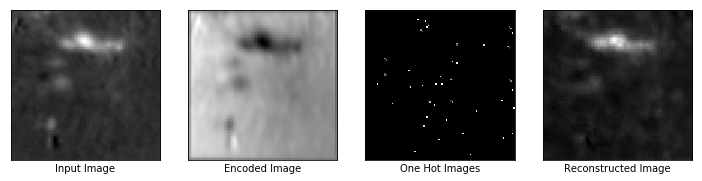

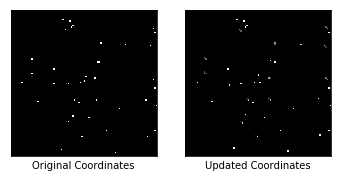

Epochs: 72, Loss: 0.002053517382591963
Similarity scores: [ 2.9482863   7.7802734   4.9496784   0.47520623  1.4335206   3.4615848
  5.397364    2.829241    4.624343    3.7718384   3.0098557   2.2435255
  5.117148    5.5422378   3.2253132   0.8562398   2.7574546   7.9195557
  7.163104    5.8725023   5.7967806   6.0111475   4.1284094   1.6983197
  7.339567    4.591306   -0.03516057  3.5112033   1.8733264   7.473201
  2.9793625  -1.5925934   4.0247045   3.9814625   3.3855996   3.7366374
  4.484173   -0.18397035  4.705658    2.4534392 ]
Updated Coordinates: [[[0.65643275 0.82762986]]]
Gradient min:-0.0010611035395413637, max:0.0011565597960725427



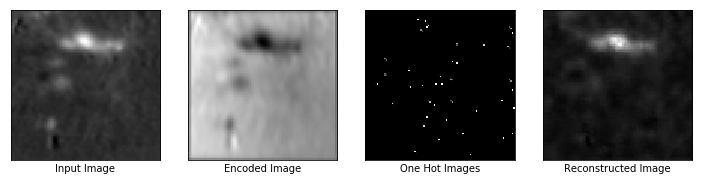

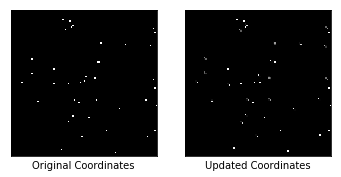

Epochs: 73, Loss: 0.0018783314153552055
Similarity scores: [ 3.042664    7.8641376   5.0811057   0.94667715  1.4352779   3.545468
  5.509664    3.008885    4.9459305   4.0090585   3.0908308   2.4498858
  5.385792    5.649733    3.5707922   1.1144749   2.925186    8.044283
  7.243774    5.993547    5.878613    6.348639    4.5544024   1.9661592
  7.3899155   5.073686    0.5507739   3.6708484   2.0506167   7.4915385
  3.140963   -1.5075837   4.159606    4.1432467   3.5229986   3.8420718
  4.7940683   0.3015062   4.767935    2.7000117 ]
Updated Coordinates: [[[0.65650773 0.8275027 ]]]
Gradient min:-0.0010326083283871412, max:0.0005648506339639425



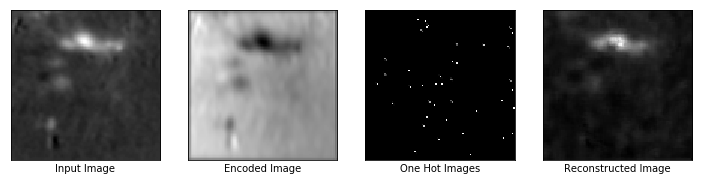

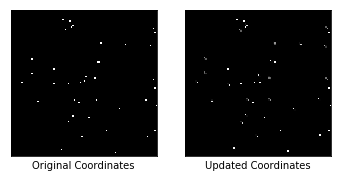

Epochs: 74, Loss: 0.0018122019246220589
Similarity scores: [ 3.231709   7.9755516  5.2106147  0.9587481  1.4423493  3.7260032
  5.67332    3.244009   5.08812    4.0917897  3.2398937  2.5911484
  5.510898   5.797737   3.8301232  1.2824553  3.1168895  8.185567
  7.4993324  6.1954327  6.0763574  6.489204   4.768572   2.0122395
  7.5602255  5.3414106  0.7090191  3.8065486  2.139792   7.604892
  3.2606337 -1.5750487  4.2963233  4.286775   3.7004166  4.068003
  4.9170218  0.3639513  4.9959626  2.8904996]
Updated Coordinates: [[[0.6565339 0.8274224]]]
Gradient min:-0.0007125924457795918, max:0.0006349536124616861



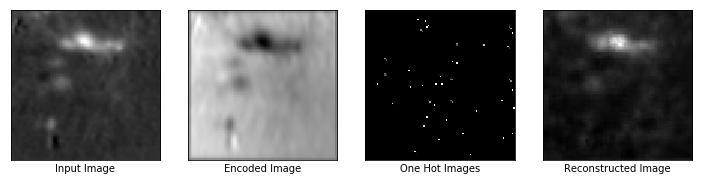

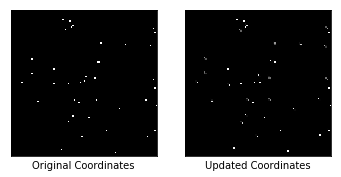

Epochs: 75, Loss: 0.0018223843071609735
Similarity scores: [ 3.394175   7.704466   5.0491133  1.1753023  1.3673053  3.8253102
  5.6808004  3.539475   4.8916097  3.8861427  3.1133657  2.5772488
  5.287489   5.7732434  4.0326347  1.5584037  3.290092   7.9044695
  7.5126534  6.196162   6.081411   6.302458   4.9023495  2.0461037
  7.372585   5.4649243  0.7606173  3.7866113  2.13896    7.309662
  3.2796466 -1.580186   4.268652   4.2923045  3.7849476  4.272127
  4.738698   0.5570374  5.105727   3.1059613]
Updated Coordinates: [[[0.65654016 0.82738906]]]
Gradient min:-0.0005817681085318327, max:0.0010477056493982673



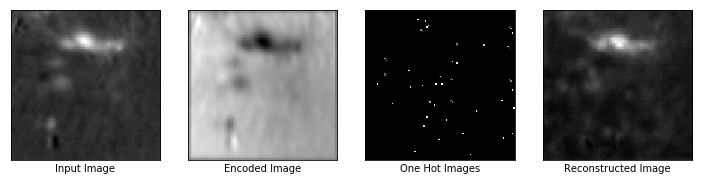

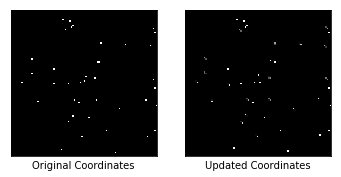

Epochs: 76, Loss: 0.0017917780205607414
Similarity scores: [ 3.608203    7.5536776   4.9352107   1.5412071   1.2936306   3.9707866
  5.7940836   3.8935292   4.738518    3.7065396   2.9871347   2.5957532
  5.1106324   5.854612    4.370973    1.883459    3.541939    7.7250915
  7.630543    6.3053493   6.182664    6.183669    5.209806    2.1346588
  7.3017893   5.7668767   0.84023935  3.818776    2.1667504   7.1305814
  3.3665059  -1.6640372   4.304689    4.362909    3.9276402   4.5521307
  4.6045337   0.8230901   5.2753115   3.4264026 ]
Updated Coordinates: [[[0.65653807 0.8274055 ]]]
Gradient min:-0.0005378472269512713, max:0.0010555667104199529



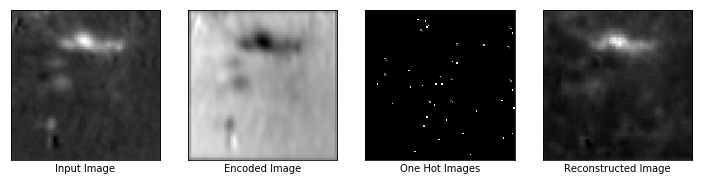

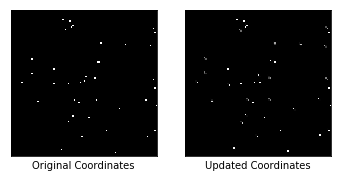

Epochs: 77, Loss: 0.0019352176459506154
Similarity scores: [ 3.693558   7.183648   4.7071137  1.7832375  1.2157208  4.001216
  5.743213   4.09149    4.4991717  3.4791424  2.7712402  2.5692444
  4.84937    5.7726808  4.510932   2.1067328  3.653682   7.3267
  7.504425   6.2187395  6.0994735  5.9433703  5.3397202  2.2205417
  7.0000806  5.8626757  0.9373505  3.7632198  2.173747   6.7292295
  3.361473  -1.6818222  4.242442   4.3229413  3.9560769  4.637642
  4.383798   1.0151485  5.280726   3.6099923]
Updated Coordinates: [[[0.6566107  0.82735527]]]
Gradient min:-0.0007797606522217393, max:0.0014663907932117581



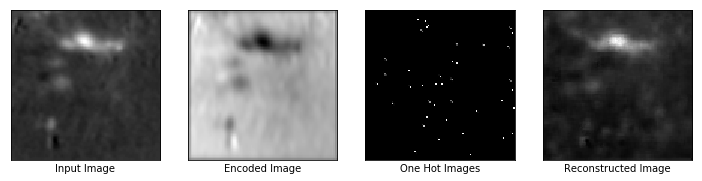

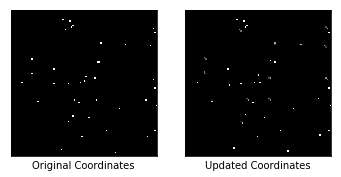

Epochs: 78, Loss: 0.002026020083576441
Similarity scores: [ 3.7639768  6.809773   4.449957   2.2200847  1.1096158  3.9904807
  5.682611   4.30138    4.284057   3.2751465  2.518919   2.540559
  4.62562    5.684862   4.7497973  2.3343349  3.7748547  6.934589
  7.328754   6.1026707  5.970688   5.746591   5.6215763  2.345401
  6.689669   6.069613   1.2902622  3.704332   2.1965554  6.320477
  3.3654501 -1.7020463  4.166946   4.2887273  3.9732435  4.7094097
  4.175017   1.450484   5.2300153  3.8448505]
Updated Coordinates: [[[0.6568007 0.8271837]]]
Gradient min:-0.0009012857335619628, max:0.0016016485169529915



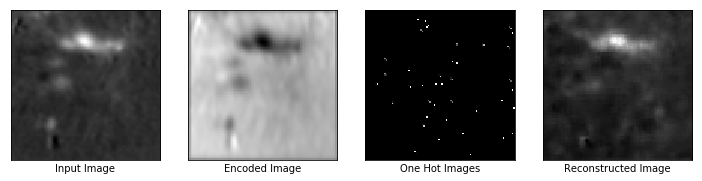

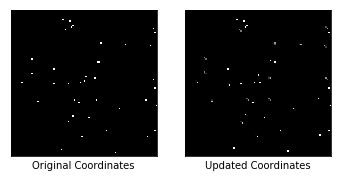

Epochs: 79, Loss: 0.002376629738137126
Similarity scores: [ 3.6320786  6.3602047  4.1735225  2.5563335  0.9833165  3.8082185
  5.445922   4.2840962  4.136728   3.1381066  2.2251754  2.5101762
  4.4947715  5.431766   4.8751035  2.4437077  3.7385504  6.510141
  6.8135467  5.765438   5.599708   5.591785   5.810039   2.4425185
  6.190516   6.2223496  1.689221   3.589315   2.2135959  5.812492
  3.3083117 -1.663009   4.0085306  4.1583605  3.8628213  4.535554
  4.0337625  1.7457812  4.9327927  3.9359345]
Updated Coordinates: [[[0.6570641 0.8269049]]]
Gradient min:-0.0013301464496180415, max:0.0022470331750810146



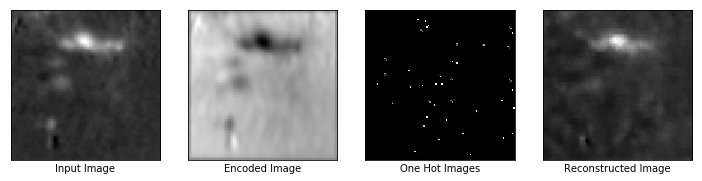

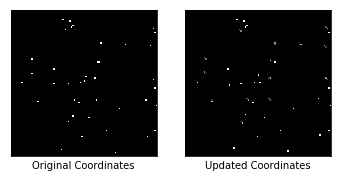

Epochs: 80, Loss: 0.0024614427238702774
Similarity scores: [ 3.3856132  6.6276355  4.4089217  2.632818   0.9877195  3.663965
  5.4619975  4.0261965  4.6312947  3.5590146  2.2475042  2.7446306
  5.100349   5.473816   5.0465536  2.4604948  3.6327353  6.892722
  6.5294375  5.699712   5.4650936  6.193813   6.3118596  2.7393627
  6.2355466  6.778432   2.447799   3.7373166  2.4353843  5.9929442
  3.4281073 -1.5398507  4.123867   4.2656465  3.843337   4.2006426
  4.50805    2.0004508  4.6933575  3.9249551]
Updated Coordinates: [[[0.6572315 0.8267532]]]
Gradient min:-0.0017498874804005027, max:0.0025925314985215664



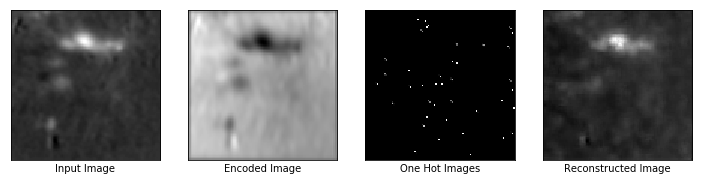

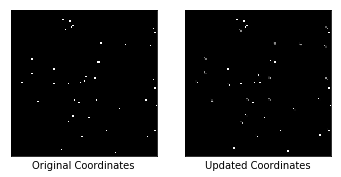

Epochs: 81, Loss: 0.0027012000791728497
Similarity scores: [ 3.182722   7.624978   5.0578494  2.0246491  1.1266378  3.662742
  5.7830014  3.6504214  5.3487206  4.1843486  2.589733   2.9608939
  5.981651   5.853222   4.904237   2.133574   3.4791808  7.9713726
  6.812208   6.0404315  5.7533526  7.078951   6.455167   2.7608607
  6.955515   7.0573764  2.1054394  4.0302672  2.5829191  6.933735
  3.593315  -1.6250566  4.445494   4.539198   3.9235392  3.9882054
  5.210593   1.5564969  4.727675   3.6717513]
Updated Coordinates: [[[0.65709317 0.8268867 ]]]
Gradient min:-0.001930399565026164, max:0.0025943296495825052



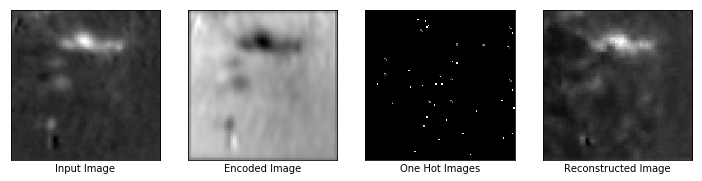

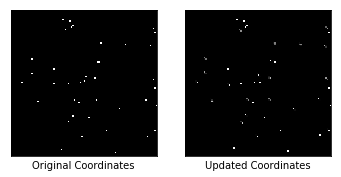

Epochs: 82, Loss: 0.0027564403135329485
Similarity scores: [ 3.2738404  7.575726   4.9619017  2.0658498  1.0406995  3.7461603
  5.884966   3.8063552  5.2344155  4.0262637  2.4416318  2.9234402
  5.8041034  5.938698   5.0772457  2.1164205  3.5697885  7.8843637
  6.9382234  6.1568074  5.8626866  6.9866247  6.5827312  2.7819107
  6.951937   7.2561855  1.5973115  4.0144525  2.5523136  6.8566494
  3.6203573 -1.7057015  4.4538345  4.5656285  3.9869652  4.193908
  5.099692   1.3266337  4.847605   3.78883  ]
Updated Coordinates: [[[0.6569526 0.8270158]]]
Gradient min:-0.001657035667449236, max:0.0023117095697671175



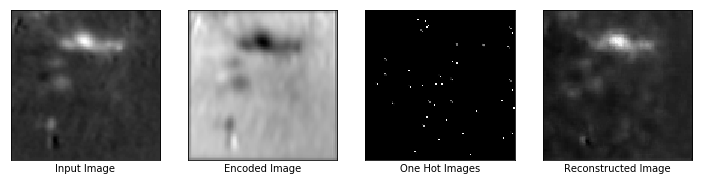

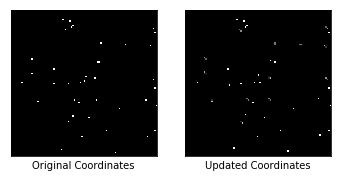

Epochs: 83, Loss: 0.0022102498915046453
Similarity scores: [ 3.4019234  6.799823   4.425557   2.3212547  0.7905657  3.7245557
  5.733996   4.2276993  4.971807   3.6858215  1.9858698  2.9080446
  5.309938   5.7031198  5.7074566  2.460284   3.8034954  7.119842
  6.5911093  5.9391007  5.5965643  6.6127863  7.064562   3.0133524
  6.299595   7.9232793  1.2702246  3.8813624  2.5583637  6.0374126
  3.6479728 -1.6597806  4.2802653  4.46572    3.9870558  4.439098
  4.8294406  1.2714647  4.744539   4.2370176]
Updated Coordinates: [[[0.65690947 0.8270622 ]]]
Gradient min:-0.001028573140501976, max:0.0006621757638640702



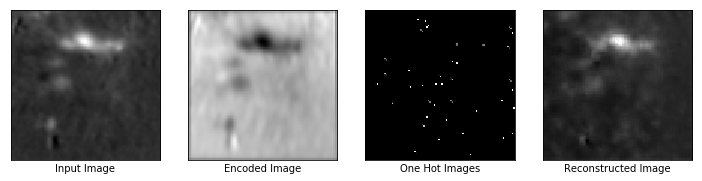

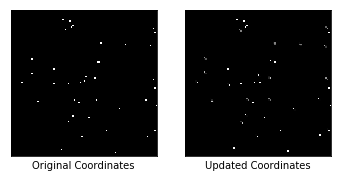

Epochs: 84, Loss: 0.0021394602954387665
Similarity scores: [ 3.7145033   6.442291    4.2100224   3.1196826   0.65113986  3.9007235
  5.817938    4.8374066   4.849294    3.5083957   1.7799155   2.9926476
  5.0845766   5.719552    6.2951865   2.992318    4.1876287   6.7627435
  6.6348915   5.9843717   5.6302853   6.489767    7.67078     3.2634985
  6.0497155   8.425916    1.714371    3.9321907   2.6718273   5.6283474
  3.7935042  -1.7066247   4.305941    4.566762    4.187776    4.826393
  4.6929727   1.8037567   4.9149117   4.8156085 ]
Updated Coordinates: [[[0.6569042 0.8270564]]]
Gradient min:-0.000889830116648227, max:0.0005044923163950443



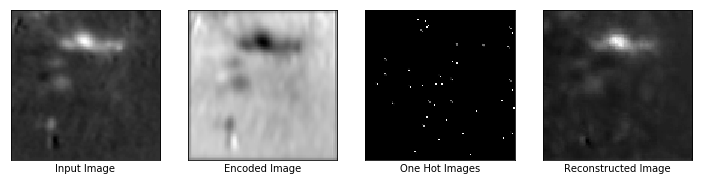

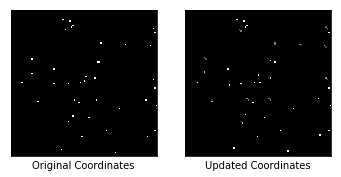

Epochs: 85, Loss: 0.0021037044934928417
Similarity scores: [ 3.9841309  6.108961   3.949497   3.5651634  0.5336392  4.07337
  5.8722     5.290165   4.6355705  3.2640269  1.6341672  2.9773343
  4.758769   5.7137666  6.5858145  3.3313596  4.4490037  6.407123
  6.761788   6.0390944  5.691979   6.2248273  7.8674297  3.2866948
  5.8323283  8.603217   1.4521499  3.9126189  2.6580634  5.2785187
  3.844576  -1.7170519  4.2850327  4.590339   4.3237667  5.1925063
  4.4768705  1.9514086  5.1058044  5.151403 ]
Updated Coordinates: [[[0.65686303 0.82708716]]]
Gradient min:-0.0008969134651124477, max:0.0005686614313162863



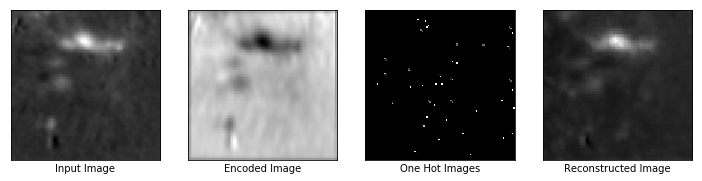

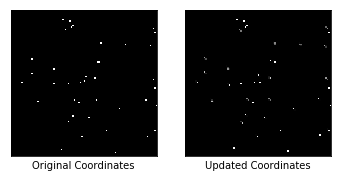

Epochs: 86, Loss: 0.002105460036545992
Similarity scores: [ 4.2836356   5.843325    3.6303883   4.1311636   0.40859234  4.274057
  5.9553795   5.7813654   4.435738    3.0147457   1.5463971   2.9713147
  4.447961    5.745489    6.879783    3.7508962   4.7326665   6.0974507
  6.963447    6.1508946   5.8126545   5.9750047   8.047172    3.2601476
  5.690472    8.709285    1.3659691   3.8955643   2.6357927   5.0021434
  3.8889332  -1.8352572   4.276918    4.6223245   4.4826508   5.5996656
  4.2613344   2.1933777   5.3505783   5.4961066 ]
Updated Coordinates: [[[0.6568664 0.8270743]]]
Gradient min:-0.0010660734260454774, max:0.000726628175470978



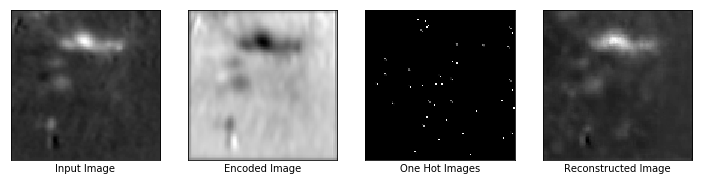

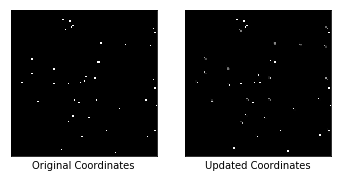

Epochs: 87, Loss: 0.0020318797323852777
Similarity scores: [ 4.410024    5.5294185   3.3641207   4.3695545   0.31995848  4.328406
  5.9125276   6.0148664   4.1972194   2.775626    1.4020442   2.8998318
  4.1593933   5.659309    7.0047984   3.941363    4.8430004   5.7344933
  6.941074    6.1017237   5.7751923   5.7073894   8.081014    3.1986697
  5.4701986   8.715935    1.4065661   3.8091238   2.5835106   4.674935
  3.8543708  -1.9100615   4.188723    4.561061    4.506513    5.8004107
  4.0247726   2.3776731   5.4006605   5.6486707 ]
Updated Coordinates: [[[0.65685904 0.82707167]]]
Gradient min:-0.0009690365986898541, max:0.0006436108378693461



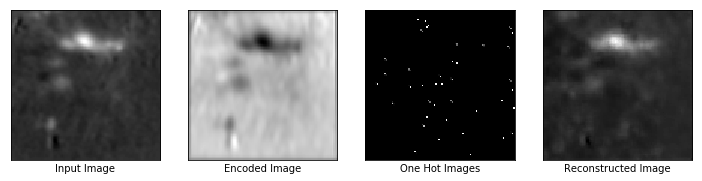

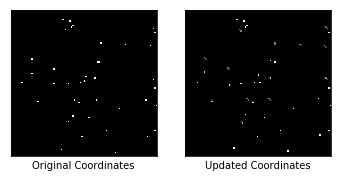

Epochs: 88, Loss: 0.0019496491877362132
Similarity scores: [ 4.5272174   5.3965273   3.169133    4.3866563   0.29668286  4.407161
  5.9266105   6.125266    3.9805405   2.5581377   1.3743163   2.8067136
  3.8740191   5.6587      7.007173    3.9835825   4.897064    5.532429
  7.088478    6.1507845   5.849013    5.4526906   7.975712    3.1013353
  5.449781    8.567571    1.1679829   3.7425516   2.4930744   4.5835605
  3.8139346  -2.002893    4.1402245   4.526156    4.5344925   5.967902
  3.8142498   2.2816164   5.5277123   5.6695824 ]
Updated Coordinates: [[[0.65686345 0.8270642 ]]]
Gradient min:-0.0010020051850005984, max:0.0007770253578200936



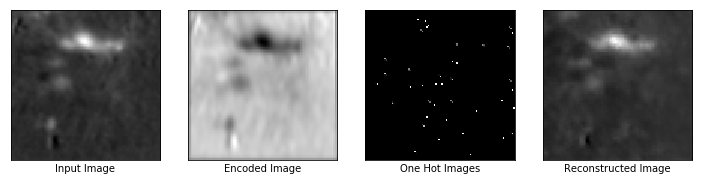

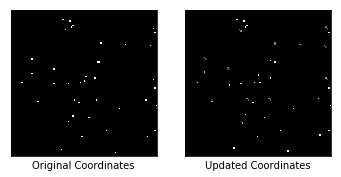

Epochs: 89, Loss: 0.0018940891604870558
Similarity scores: [ 4.591939   5.2146883  2.999345   4.4999557  0.2556117  4.4272738
  5.896748   6.2327776  3.7891319  2.377888   1.3088746  2.717595
  3.656374   5.6049685  7.034299   4.0634856  4.934032   5.3180046
  7.1143985  6.1295033  5.841683   5.2410836  7.929406   3.0000286
  5.3503304  8.455716   1.2686042  3.6665437  2.4093206  4.4257326
  3.7621982 -2.1076941  4.0680885  4.4678283  4.525794   6.0608478
  3.6269464  2.4355934  5.5644355  5.706079 ]
Updated Coordinates: [[[0.6568864  0.82703537]]]
Gradient min:-0.0008505157893523574, max:0.001038720365613699



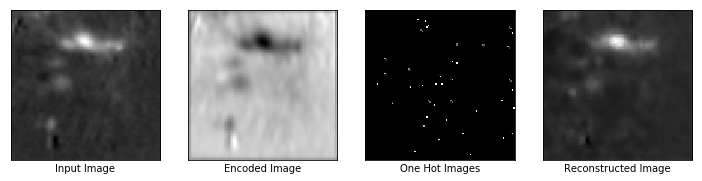

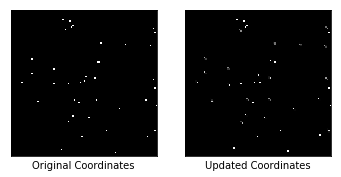

Epochs: 90, Loss: 0.001898357761092484
Similarity scores: [ 4.3988433   5.0320745   2.8707454   3.977455    0.21394587  4.2431087
  5.657825    5.949092    3.6139445   2.241488    1.2709498   2.5726383
  3.4925358   5.3749995   6.6933146   3.8776088   4.716724    5.1365137
  6.845629    5.8787766   5.607419    5.017488    7.531389    2.8152444
  5.1638684   7.9995956   1.3408467   3.492999    2.2563305   4.2836213
  3.577965   -2.2239566   3.8883312   4.2777886   4.339461    5.8219166
  3.462916    2.1171403   5.348062    5.429225  ]
Updated Coordinates: [[[0.6569022 0.8270185]]]
Gradient min:-0.0007724292227067053, max:0.0009420031565241516



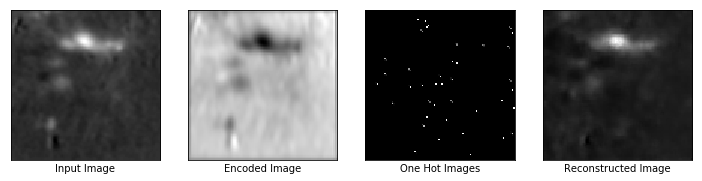

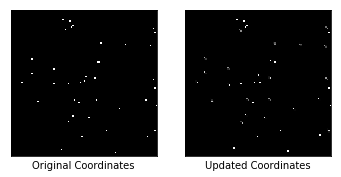

Epochs: 91, Loss: 0.0017124803271144629
Similarity scores: [ 4.3259873  4.677631   2.6562736  4.032691   0.1174901  4.1248274
  5.5073295  6.046633   3.7187867  2.2768605  1.0952712  2.6926978
  3.5325813  5.189261   7.1024814  4.128184   4.7949076  4.844035
  6.3815064  5.629875   5.2917166  5.0988073  8.033407   3.10057
  4.7381673  8.558648   1.8396636  3.4904618  2.381794   3.8573213
  3.6458924 -2.0648305  3.8257751  4.254187   4.3045225  5.6705117
  3.5593898  2.419842   5.087107   5.676116 ]
Updated Coordinates: [[[0.65691906 0.82699984]]]
Gradient min:-0.00021158352319616824, max:0.00031042247428558767



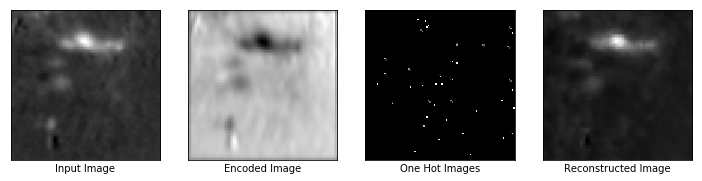

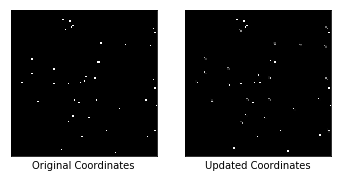

Epochs: 92, Loss: 0.0017341641942039132
Similarity scores: [ 4.6024656  4.3991065  2.4855373  4.511028   0.0922685  4.2725897
  5.5692353  6.5171175  3.5907931  2.1303535  1.0040817  2.7510448
  3.3576682  5.2286315  7.597941   4.575083   5.0934463  4.5378504
  6.4514894  5.6800184  5.343045   4.96669    8.43223    3.3073099
  4.579343   8.979664   2.0185907  3.5221324  2.4701405  3.605284
  3.7586417 -2.0382628  3.8473797  4.321307   4.4547143  6.030566
  3.4326112  2.7272327  5.2401795  6.0947385]
Updated Coordinates: [[[0.65700436 0.82691604]]]
Gradient min:-0.0003543069469742477, max:0.0004649593320209533



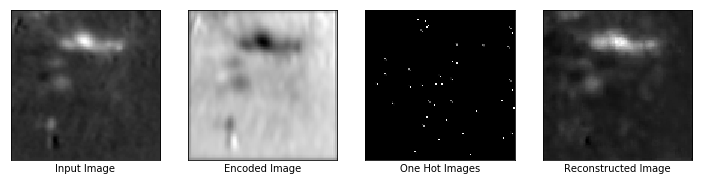

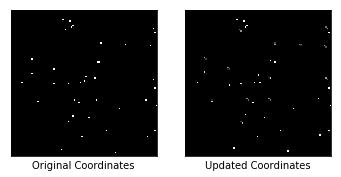

Epochs: 93, Loss: 0.001818720600567758
Similarity scores: [ 4.8130636   4.603692    2.575088    4.8615775   0.09506953  4.45533
  5.797181    6.7611256   3.6433299   2.1213238   1.0805663   2.7987835
  3.4025743   5.4582663   7.768101    4.5339866   5.2698026   4.728395
  6.802101    5.9318337   5.6013675   5.0848584   8.604032    3.3349383
  4.8439617   9.087487    2.284       3.6444829   2.521261    3.820035
  3.8650389  -2.212488    3.9955916   4.476604    4.639287    6.283705
  3.4714935   3.0086324   5.509479    6.2629833 ]
Updated Coordinates: [[[0.6571803 0.8267413]]]
Gradient min:-0.0005684690549969673, max:0.0006338914972729981



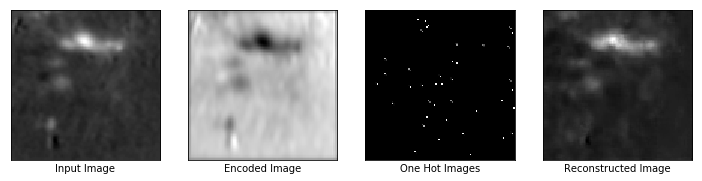

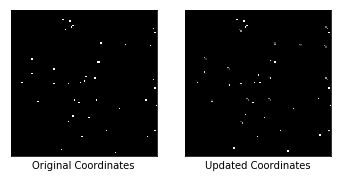

Epochs: 94, Loss: 0.0018405281007289886
Similarity scores: [ 4.8983      4.783861    2.5956545   5.268716    0.08225634  4.5354767
  5.936235    6.873747    3.78683     2.2189775   1.0308746   2.810466
  3.5836916   5.5896435   7.867354    4.6844583   5.350219    4.92889
  6.9462957   6.0406203   5.7179394   5.2884765   8.831092    3.452569
  4.981464    9.244731    2.78684     3.726481    2.5630038   3.950045
  3.9351938  -2.284038    4.0781674   4.5829306   4.707555    6.3948994
  3.6155653   3.4811702   5.596252    6.365264  ]
Updated Coordinates: [[[0.6575964 0.8263266]]]
Gradient min:-0.0011556583922356367, max:0.0007477616891264915



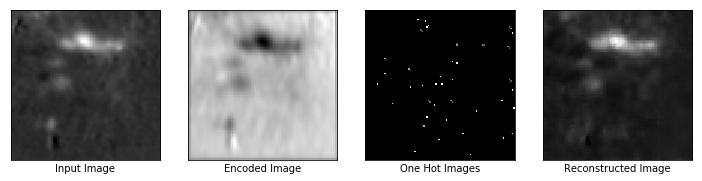

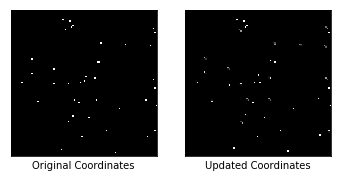

Epochs: 95, Loss: 0.0019169053994119167
Similarity scores: [ 5.0993214   4.8663015   2.6154685   5.105084    0.10929181  4.701763
  6.0930767   7.082217    3.8223429   2.259028    1.0999329   2.8512092
  3.5894315   5.7029414   8.034031    4.8728256   5.495554    4.986632
  7.1933794   6.216522    5.89407     5.2859      8.886536    3.473831
  5.1116138   9.432454    2.1272357   3.812768    2.6022797   4.0394535
  4.039499   -2.1732824   4.1685505   4.683074    4.8320327   6.6436434
  3.6511104   3.092722    5.7972574   6.502995  ]
Updated Coordinates: [[[0.6575972  0.82634157]]]
Gradient min:-0.0019117238698527217, max:0.0011538024991750717



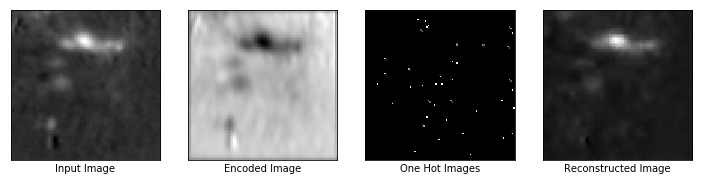

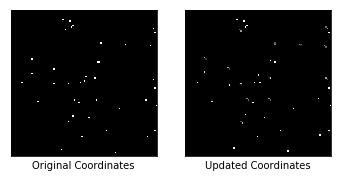

Epochs: 96, Loss: 0.0025146128609776497
Similarity scores: [ 5.235819    5.3129907   2.943906    4.893425    0.25279227  4.904626
  6.337095    7.100951    4.0798974   2.4684377   1.3917606   3.0291147
  3.848321    5.96069     8.102868    5.1754622   5.579184    5.4131103
  7.5938725   6.533503    6.2256474   5.554871    8.914465    3.5099933
  5.5540466   9.614922    1.7896488   4.002487    2.7123704   4.5121675
  4.1896577  -1.9793254   4.3809667   4.8597555   4.9909062   6.811443
  3.9027274   2.7735305   6.070699    6.502074  ]
Updated Coordinates: [[[0.6575062 0.8264437]]]
Gradient min:-0.0039667775854468346, max:0.0023345821537077427



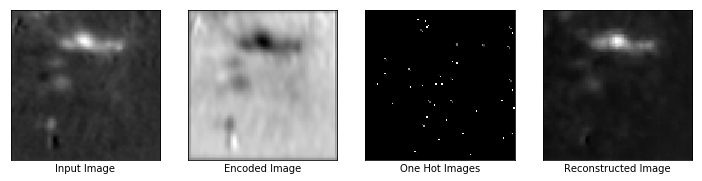

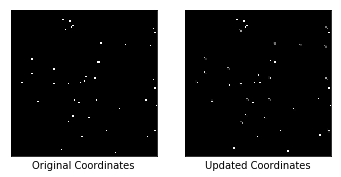

Epochs: 97, Loss: 0.0019996888004243374
Similarity scores: [ 5.687021   6.1273456  3.4562507  3.8736718  0.4441185  5.433152
  7.037157   7.382453   4.3987136  2.7341304  1.7156105  3.1763592
  4.330712   6.6614885  8.001546   4.089916   5.85804    6.214419
  8.619684   7.280833   7.019154   6.052486   8.929205   3.5117955
  6.4513884  9.285514   1.7269487  4.4222736  2.8628354  5.3010316
  4.4774065 -2.313234   4.877973   5.350906   5.456918   7.321441
  4.22259    2.002029   6.8189945  6.5938234]
Updated Coordinates: [[[0.6570142  0.82685226]]]
Gradient min:-0.002784295007586479, max:0.001523326733149588



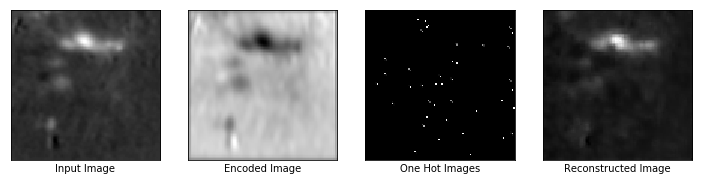

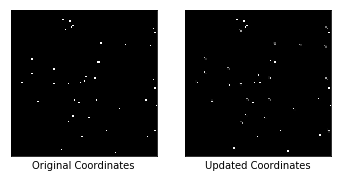

Epochs: 98, Loss: 0.001342075876891613
Similarity scores: [ 5.224222   5.9604616  3.3454103  4.041922   0.4177123  5.019851
  6.578958   6.7605824  4.19464    2.6353414  1.6317506  2.9956422
  4.159576   6.244736   7.469409   3.8837008  5.403005   6.0474176
  8.006628   6.775701   6.526286   5.78432    8.468374   3.281461
  6.1750746  8.814495   2.1142375  4.1399035  2.6878834  5.184266
  4.187332  -2.303639   4.5772886  5.0206294  5.0855746  6.6729393
  4.0325437  2.2879636  6.2974186  6.0834727]
Updated Coordinates: [[[0.6568487  0.82699585]]]
Gradient min:-0.0006641009822487831, max:0.0009704389376565814



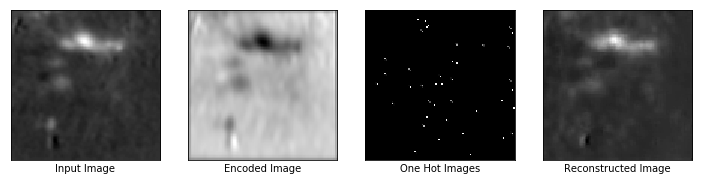

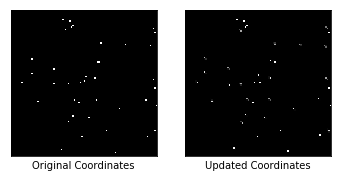

Epochs: 99, Loss: 0.001438465085811913
Similarity scores: [ 5.1622243  5.0682654  2.805978   3.9899335  0.3623245  4.7938256
  6.092697   6.678923   3.60848    2.1881876  1.3484333  2.7277515
  3.4801254  5.7405996  7.1366515  3.6576705  5.203391   5.111855
  7.501716   6.3039126  6.0858407  5.0317936  7.836439   3.183451
  5.424794   8.213246   1.4756523  3.7477727  2.4965127  4.3717265
  3.879597  -2.0566785  4.1652694  4.5914736  4.7620764  6.618018
  3.478786   1.919669   6.0293646  5.878921 ]
Updated Coordinates: [[[0.65687746 0.8269756 ]]]
Gradient min:-0.00033373109181411564, max:0.0007495690952055156



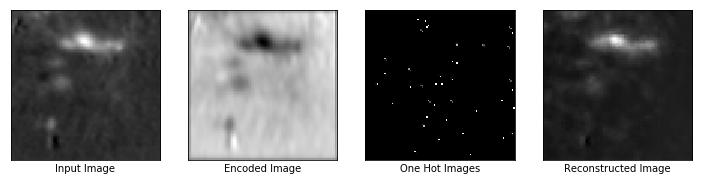

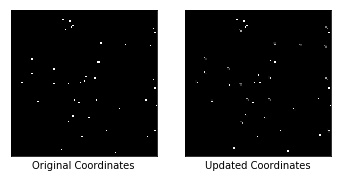

Epochs: 100, Loss: 0.0016531097935512662
Similarity scores: [ 5.634725   5.6251764  3.335043   3.7816937  0.7331549  5.255242
  6.562138   7.2468257  4.1544023  2.7187622  1.7656995  3.188115
  4.0820923  6.194409   7.8526516  4.169426   5.708111   5.717348
  8.026584   6.7819643  6.5725255  5.6012235  8.59749    3.7244778
  5.935493   8.951004   1.429659   4.2561316  2.9991567  4.9485846
  4.398481  -1.6334668  4.6432323  5.0972195  5.2075467  7.082409
  4.0127106  1.818998   6.480824   6.496183 ]
Updated Coordinates: [[[0.6571147 0.8267707]]]
Gradient min:-0.0013542742235586047, max:0.0006985198124311864


In [14]:
from utils_vis import plot_comparison

BATCH_SIZE = 8
MAX_EPOCHS = 500
batch_imgs= tf.data.Dataset.from_tensor_slices(re_list).batch(BATCH_SIZE, drop_remainder=True)

#list to be append to output 
loss_list = []
input_imgs = []
coords_list = []
encoded_imgs = []
reconstructed_imgs = []
one_hot_imgs = []
captions_01 = ['Input Image', 'Encoded Image', 'One Hot Images','Reconstructed Image']
captions_02 = ['Original Coordinates', 'Updated Coordinates']

epochs = 1
while epochs <= MAX_EPOCHS:
    #reset coords for each epochs
#     coords,_, ori_one_hot_imgs = create_dat_samples(n_neurons)
#     coords = tf.reshape(coords, [n_neurons, 1,1,2])
    for steps, batched_imgs in enumerate(batch_imgs):
        loss, updated_coords, one_hot_imgs, encoder_output, similarity_score, reconstruction, grad_model  = train_fn(batched_imgs, coords, img_size, BATCH_SIZE)
    loss_list.append(loss)
    if epochs%10==0:
        img_row01 = [batched_imgs[0], encoder_output[0], stack4plot(one_hot_imgs), reconstruction[0]]
        img_row02 = [stack4plot(ori_one_hot_imgs), stack4plot(one_hot_imgs)]
        plot_comparison(img_row01, captions_01, n_col=len(img_row01), figsize = (10, 10))
        plot_comparison(img_row02, captions_02, n_col=len(img_row02))
        print("Epochs: {}, Loss: {}".format(epochs, loss.numpy()))
        print("Similarity scores: {}".format(similarity_score[0]))
        print("Updated Coordinates: {}".format(updated_coords[0]))
        print("Gradient min:{}, max:{}".format(np.min(grad_model[0]), np.max(grad_model[0])))
    epochs+=1